# Hu et al. One Dimensional Convolutional Neural Network
In this notebook, I provide an implementation of the one dimensional convolutional neural network (1D CNN) proposed by (Hu et al., 2015) in a federated enviroment. Note the proposed 1D CNN is altered for for the purpose of binary sequence-to-label classification; corresponding comments detail all adjustments. The spectra data are first obtained from all files in the "dataset" folder.

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import flwr as fl
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
import os
import logging

# Set logging level to critical to minimize output noise
logging.getLogger("flwr").setLevel(logging.CRITICAL)

# Define device for computation (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLIENTS = 5  # Number of federated clients

In [2]:
# Load and preprocess data
def load_and_preprocess(train_file, val_file):
    """
    Load and preprocess the data from CSV files.

    Parameters:
        train_file (str): Path to the training CSV file.
        val_file (str): Path to the validation CSV file.

    Returns:
        Tuple containing training samples, training labels, validation samples, and validation labels.
    """
    # Load datasets
    train_df = pd.read_csv(train_file, header=None)
    val_df = pd.read_csv(val_file, header=None)
    
    # Extract samples and labels, converting to float
    train_samples = train_df.iloc[1:-1, 1:].values.astype(float)
    train_labels = train_df.iloc[-1, 1:].values.astype(float)
    val_samples = val_df.iloc[1:-1, 1:].values.astype(float)
    val_labels = val_df.iloc[-1, 1:].values.astype(float)
    
    # Standardize the samples
    scaler = StandardScaler()
    train_samples = scaler.fit_transform(train_samples.T).T
    val_samples = scaler.transform(val_samples.T).T
    
    return train_samples, train_labels, val_samples, val_labels

In [3]:
# 1D CNN model definition
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        # Define layers: 1D convolution, pooling, fully connected, and dropout
        self.conv1 = nn.Conv1d(1, 20, kernel_size=9)
        self.pool = nn.MaxPool1d(3)
        self.fc1 = nn.Linear(20 * 97, 100)
        self.fc2 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Forward pass through the CNN
        x = self.pool(F.relu(self.conv1(x)))  # Convolution + ReLU + Pooling
        x = x.view(x.size(0), -1)  # Flatten feature maps
        x = F.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer
        return x

In [4]:
# Early stopping criteria
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Initialize the early stopping mechanism.

        Parameters:
            patience (int): Number of epochs to wait for improvement before stopping.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Check if training should stop based on validation loss.

        Parameters:
            val_loss (float): Current validation loss.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [5]:
# Federated learning utility functions

def get_client_parameters(net) -> List[np.ndarray]:
    """
    Extract model parameters for federated learning.

    Parameters:
        net (nn.Module): The neural network model.

    Returns:
        List[np.ndarray]: Model parameters.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_client_parameters(net, parameters: List[np.ndarray]):
    """
    Set model parameters for federated learning.

    Parameters:
        net (nn.Module): The neural network model.
        parameters (List[np.ndarray]): List of model parameters.
    """
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [6]:
# Test the client model
def test_client_model(net, testloader):
    """
    Evaluate the model on the test set.

    Parameters:
        net (nn.Module): The neural network model.
        testloader (DataLoader): DataLoader for the test set.

    Returns:
        Tuple containing loss, accuracy, precision, recall, and F1 score.
    """
    criterion = nn.BCEWithLogitsLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = net(inputs).squeeze()
            loss += criterion(outputs, labels).item()
            preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid to get probabilities
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Calculate metrics
    loss /= len(testloader.dataset)
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return loss, accuracy, precision, recall, f1

In [7]:
# Train the client model
def train_client_model(net, trainloader, valloader, epochs: int, patience: int = 5, client_id: int = 0):
    """
    Train the model on the client's local dataset.

    Parameters:
        net (nn.Module): The neural network model.
        trainloader (DataLoader): DataLoader for the training set.
        valloader (DataLoader): DataLoader for the validation set.
        epochs (int): Number of training epochs.
        patience (int): Patience for early stopping.
        client_id (int): Identifier for the client.
    """
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        net.train()  # Set model to training mode
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        val_loss, val_accuracy, _, _, _ = test_client_model(net, valloader)
        print(f"Epoch {epoch+1}: val loss {val_loss:.4f}, val accuracy {val_accuracy:.4f}")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(net.state_dict(), f"best_model_client_{client_id}.pt")
        else:
            patience_counter += 1

        # Stop training if 100% accuracy is achieved
        if val_accuracy == 1.0:
            print(f"Early stopping due to reaching 100% accuracy")
            break

In [8]:
# Define the FlowerClient class for federated learning
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        """
        Initialize a federated learning client.

        Parameters:
            cid (int): Client ID.
            net (nn.Module): The neural network model.
            trainloader (DataLoader): DataLoader for the training set.
            valloader (DataLoader): DataLoader for the validation set.
        """
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        """Return the model parameters."""
        print(f"[Client {self.cid}] get_parameters")
        return get_client_parameters(self.net)

    def fit(self, parameters, config):
        """Train the model on local data."""
        print(f"[Client {self.cid}] fit, config: {config}")
        set_client_parameters(self.net, parameters)
        train_client_model(self.net, self.trainloader, self.valloader, epochs=20, patience=5, client_id=self.cid)
        return get_client_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        """Evaluate the model on local validation data."""
        print(f"[Client {self.cid}] evaluate, config: {config}")
        # Set the model parameters with the latest global parameters
        set_client_parameters(self.net, parameters)
        # Evaluate the model
        loss, accuracy, precision, recall, f1 = test_client_model(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {
            "accuracy": float(accuracy),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1)
        }

In [9]:
# Create a Flower client
def client_fn(cid) -> FlowerClient:
    """
    Create and initialize a FlowerClient instance for a given client ID.

    Parameters:
        cid (int): Client ID.

    Returns:
        FlowerClient: Configured FlowerClient instance.
    """
    # Initialize the CNN model
    net = CNN1D().to(DEVICE)
    # Define file paths for training and validation data
    train_file = f"../No_MSC/Seed_{seed_index}/Client_{cid}_Train.csv"
    val_file = f"../No_MSC/Seed_{seed_index}/Client_{cid}_Validation.csv"
    
    # Load and preprocess the data
    train_samples, train_labels, val_samples, val_labels = load_and_preprocess(train_file, val_file)
    
    # Convert data to PyTorch tensors and add channel dimension for 1D CNN
    X_train = torch.tensor(train_samples.T, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(train_labels, dtype=torch.float32)
    X_val = torch.tensor(val_samples.T, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(val_labels, dtype=torch.float32)

    # Create TensorDatasets and DataLoaders for training and validation
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return FlowerClient(cid, net, train_loader, val_loader)

In [10]:
# Load combined validation dataset for evaluation
def load_combined_validation(seed_index):
    """
    Load and preprocess the combined validation dataset for all clients.

    Parameters:
        seed_index (int): Index of the seed for data partitioning.

    Returns:
        DataLoader: DataLoader for the combined validation dataset.
    """
    # Define file path for the combined validation set
    val_file = f"../No_MSC/Seed_{seed_index}/Combined_Validation.csv"
    # Load and preprocess the combined validation data
    _, _, val_samples, val_labels = load_and_preprocess(val_file, val_file)
    # Convert samples and labels to PyTorch tensors
    X_val = torch.tensor(val_samples.T, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(val_labels, dtype=torch.float32)
    # Create TensorDataset and DataLoader
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return val_loader

In [11]:
# Evaluate the aggregated model on the combined validation dataset
def evaluate_aggregated_model(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    """
    Evaluate the aggregated model on the combined validation dataset.

    Parameters:
        server_round (int): Current round of federated learning.
        parameters (fl.common.NDArrays): Aggregated model parameters from the server.
        config (Dict[str, fl.common.Scalar]): Configuration dictionary.

    Returns:
        Optional[Tuple[float, Dict[str, fl.common.Scalar]]]: 
        Evaluation loss and a dictionary of aggregated evaluation metrics.
    """
    global best_aggregated_acc
    # Initialize the neural network model
    net = CNN1D().to(DEVICE)
    # Load the latest parameters into the model
    set_client_parameters(net, parameters)
    # Evaluate the model on the combined validation set
    loss, accuracy, precision, recall, f1 = test_client_model(net, combined_val_loader)
    print(f"Server-side evaluation - loss: {loss}, accuracy: {accuracy}")

    # Save the best model based on validation accuracy
    if accuracy > best_aggregated_acc:
        best_aggregated_acc = accuracy
        torch.save(net.state_dict(), "best_aggregated_model.pt")
        print(f"Best aggregated model saved with accuracy {accuracy}")

    return loss, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [12]:
# Define metric aggregation function using arithmetic mean
def arithmetic_mean(metrics: List[Tuple[int, Dict[str, fl.common.Scalar]]]) -> Dict[str, fl.common.Scalar]:
    """
    Compute the arithmetic mean of metrics across all clients.

    Parameters:
        metrics (List[Tuple[int, Dict[str, fl.common.Scalar]]]): 
        List of tuples containing number of samples and metric dictionaries from clients.

    Returns:
        Dict[str, fl.common.Scalar]: Aggregated metrics.
    """
    # Extract accuracy and calculate mean
    accuracies = [m["accuracy"] for _, m in metrics]
    mean_acc = np.mean(accuracies)
    # Extract precision and calculate mean
    precisions = [m["precision"] for _, m in metrics]
    mean_precision = np.mean(precisions)
    # Extract recall and calculate mean
    recalls = [m["recall"] for _, m in metrics]
    mean_recall = np.mean(recalls)
    # Extract F1 score and calculate mean
    f1_scores = [m["f1"] for _, m in metrics]
    mean_f1 = np.mean(f1_scores)
    return {"accuracy": mean_acc, "precision": mean_precision, "recall": mean_recall, "f1": mean_f1}

In [13]:
# Training and evaluation loop for federated learning
# Initialize the combined validation dataset loader for each seed
combined_val_loaders = []

# Store metrics for analysis
all_metrics = []

# Train and evaluate the federated model across 30 seeds
for seed_index in range(30):
    print(f"Seed {seed_index+1}/30")

    # Load the combined validation dataset for the current seed
    combined_val_loader = load_combined_validation(seed_index)
    combined_val_loaders.append(combined_val_loader)

    # Reset best aggregated accuracy for each seed
    best_aggregated_acc = 0.0

    # Define the federated learning strategy
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Use all clients for training in each round
        fraction_evaluate=1.0,  # Use all clients for evaluation in each round
        min_fit_clients=5,  # Minimum number of clients required for training
        min_evaluate_clients=5,  # Minimum number of clients required for evaluation
        min_available_clients=NUM_CLIENTS,  # Minimum number of total clients
        initial_parameters=fl.common.ndarrays_to_parameters(get_client_parameters(CNN1D())),
        evaluate_fn=evaluate_aggregated_model,  # Evaluation function for server-side evaluation
        evaluate_metrics_aggregation_fn=arithmetic_mean,  # Metric aggregation function
    )

    client_resources = None
    if DEVICE.type == "cuda":
        client_resources = {"num_gpus": 1}

    # Start the federated learning simulation
    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=50),  # Number of training rounds
        strategy=strategy,
        client_resources=client_resources,
    )

    # Load and evaluate the best aggregated model for the current seed
    aggregated_model_path = "best_aggregated_model.pt"
    aggregated_model = CNN1D().to(DEVICE)
    if os.path.exists(aggregated_model_path):
        aggregated_model.load_state_dict(torch.load(aggregated_model_path))
        loss, accuracy, precision, recall, f1 = test_client_model(aggregated_model, combined_val_loader)
        print(f"Aggregated model evaluation - loss: {loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}")
        all_metrics.append((loss, accuracy, precision, recall, f1))

Seed 1/30


2024-08-03 02:06:34,784	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.026098317570156522, accuracy: 0.4074074074074074
Best aggregated model saved with accuracy 0.4074074074074074
(ClientAppActor pid=8863) [Client 0] fit, config: {}


(ClientAppActor pid=8863) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8862) Epoch 1: val loss 0.0184, val accuracy 0.8571
(ClientAppActor pid=8862) Epoch 2: val loss 0.0151, val accuracy 0.8571
(ClientAppActor pid=8862) Epoch 3: val loss 0.0183, val accuracy 0.8571
(ClientAppActor pid=8865) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=8862) Early stopping at epoch 8
Server-side evaluation - loss: 0.016886654275434988, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=8866) [Client 0] evaluate, config: {}
(ClientAppActor pid=8865) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.01296922426532816, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
Server-side evaluation - loss: 0.011239106318464986, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
Server-side evaluation - loss: 0.00988665802611245, accuracy: 0.9074074074074074
Server-side evaluation 

(ClientAppActor pid=8865) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 156x across cluster]


Server-side evaluation - loss: 0.006778627013166745, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.006803661274413268, accuracy: 0.9166666666666666
(ClientAppActor pid=8862) Epoch 1: val loss 0.0003, val accuracy 1.0000 [repeated 456x across cluster]
(ClientAppActor pid=8862) Early stopping due to reaching 100% accuracy [repeated 35x across cluster]
Server-side evaluation - loss: 0.007300718549501013, accuracy: 0.9074074074074074
(ClientAppActor pid=8865) Early stopping at epoch 7 [repeated 54x across cluster]
Server-side evaluation - loss: 0.007512635654873318, accuracy: 0.8981481481481481
(ClientAppActor pid=8864) [Client 4] evaluate, config: {} [repeated 94x across cluster]
Server-side evaluation - loss: 0.006162805551732028, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.0062171270794890545, accuracy: 0.9351851851851852
Server-side evaluation - loss: 0.007111644958732305, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.007226125613130905

(ClientAppActor pid=8865) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 189x across cluster]


Server-side evaluation - loss: 0.006459221519805767, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.00666796447088321, accuracy: 0.9166666666666666
(ClientAppActor pid=8863) Epoch 13: val loss 0.0283, val accuracy 0.9000 [repeated 439x across cluster]
(ClientAppActor pid=8862) Early stopping due to reaching 100% accuracy [repeated 40x across cluster]
(ClientAppActor pid=8863) Early stopping at epoch 14 [repeated 52x across cluster]
Server-side evaluation - loss: 0.00719510900132634, accuracy: 0.8981481481481481
(ClientAppActor pid=8864) [Client 2] evaluate, config: {} [repeated 95x across cluster]
Server-side evaluation - loss: 0.006536240068574746, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.009236413123155082, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.006951194187557256, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.007521417405870225, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.007214457658981836,

(ClientAppActor pid=8866) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 154x across cluster]
2024-08-03 02:06:54,001	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025892025342694035, accuracy: 0.46296296296296297
Best aggregated model saved with accuracy 0.46296296296296297


(ClientAppActor pid=8910) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8913) [Client 1] fit, config: {}
(ClientAppActor pid=8913) Epoch 1: val loss 0.0438, val accuracy 0.7500
(ClientAppActor pid=8913) Early stopping at epoch 7
Server-side evaluation - loss: 0.016511791558177384, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=8913) [Client 2] evaluate, config: {}
(ClientAppActor pid=8910) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.012788708425230451, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0.01579251485290351, accuracy: 0.7685185185185185
Server-side evaluation - loss: 0.013179385275752456, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.013465054195236277, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.011948408489977871, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluati

(ClientAppActor pid=8910) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 116x across cluster]


Server-side evaluation - loss: 0.012931285426020622, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.010264732978410192, accuracy: 0.8796296296296297
(ClientAppActor pid=8911) Epoch 7: val loss 0.0354, val accuracy 0.9048 [repeated 483x across cluster]
(ClientAppActor pid=8910) Early stopping at epoch 12 [repeated 34x across cluster]
Server-side evaluation - loss: 0.013464549487387692, accuracy: 0.8611111111111112
(ClientAppActor pid=8914) [Client 4] evaluate, config: {} [repeated 74x across cluster]
Server-side evaluation - loss: 0.010651355471324038, accuracy: 0.8796296296296297
(ClientAppActor pid=8912) Early stopping due to reaching 100% accuracy [repeated 31x across cluster]
Server-side evaluation - loss: 0.01224563408780981, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.013415674920435305, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.015300876012554875, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012579161742771114,

(ClientAppActor pid=8910) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 170x across cluster]


Server-side evaluation - loss: 0.023158505627954448, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.026542253861272777, accuracy: 0.8518518518518519
(ClientAppActor pid=8912) Epoch 7: val loss 0.0437, val accuracy 0.9524 [repeated 458x across cluster]
(ClientAppActor pid=8912) Early stopping at epoch 9 [repeated 45x across cluster]
Server-side evaluation - loss: 0.020396109049518902, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.023301990012879723, accuracy: 0.8703703703703703
(ClientAppActor pid=8910) [Client 2] evaluate, config: {} [repeated 86x across cluster]
(ClientAppActor pid=8913) Early stopping due to reaching 100% accuracy [repeated 42x across cluster]
Server-side evaluation - loss: 0.023823610955366382, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.023866043529576726, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.024148704622078826, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.02399621876301589, 

(ClientAppActor pid=8913) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 179x across cluster]


Server-side evaluation - loss: 0.028213858604431152, accuracy: 0.8703703703703703
(ClientAppActor pid=8910) Epoch 8: val loss 0.0043, val accuracy 0.9500 [repeated 406x across cluster]
(ClientAppActor pid=8911) Early stopping at epoch 7 [repeated 40x across cluster]
Server-side evaluation - loss: 0.02874613856827771, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.03172242882902975, accuracy: 0.8611111111111112
Aggregated model evaluation - loss: 0.01160799705043987, accuracy: 0.8796296296296297, precision: 0.8571428571428571, recall: 0.9523809523809523, f1: 0.9022556390977443
Seed 3/30
(ClientAppActor pid=8913) [Client 3] evaluate, config: {} [repeated 85x across cluster]
(ClientAppActor pid=8912) Early stopping due to reaching 100% accuracy [repeated 44x across cluster]
(ClientAppActor pid=8914) [Client 3] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=8914) Epoch 9: val loss 0.0613, val accuracy 0.9524 [repeated 38x across cluster]
(ClientAppActor pi

(ClientAppActor pid=8912) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 34x across cluster]
2024-08-03 02:07:15,603	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025532798634635076, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=8952) [Client 2] fit, config: {}


(ClientAppActor pid=8951) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8952) Epoch 1: val loss 0.0081, val accuracy 1.0000
(ClientAppActor pid=8952) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=8949) Early stopping at epoch 7
Server-side evaluation - loss: 0.018097598519590165, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=8952) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.016157707958309737, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.012926677310908283, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
Server-side evaluation - loss: 0.013267987028316216, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
Server-side evaluation - loss: 0.013433607226168667, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.00991423041732223, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
Server-side 

(ClientAppActor pid=8951) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 166x across cluster]


Server-side evaluation - loss: 0.007828236798997279, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.010879458928549732, accuracy: 0.8981481481481481
(ClientAppActor pid=8950) Epoch 1: val loss 0.0001, val accuracy 1.0000 [repeated 456x across cluster]
(ClientAppActor pid=8950) Early stopping due to reaching 100% accuracy [repeated 40x across cluster]
(ClientAppActor pid=8948) Early stopping at epoch 7 [repeated 53x across cluster]
Server-side evaluation - loss: 0.010437533259391785, accuracy: 0.8981481481481481
(ClientAppActor pid=8950) [Client 0] evaluate, config: {} [repeated 99x across cluster]
Server-side evaluation - loss: 0.012278005204818867, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.011910884606617468, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.008547899485738189, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.00969545281043759, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.010065237060189247, 

(ClientAppActor pid=8951) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 229x across cluster]


Server-side evaluation - loss: 0.012318115267488692, accuracy: 0.9074074074074074
(ClientAppActor pid=8951) Epoch 6: val loss 0.0270, val accuracy 0.9048 [repeated 382x across cluster]
(ClientAppActor pid=8948) Early stopping due to reaching 100% accuracy [repeated 70x across cluster]
Server-side evaluation - loss: 0.014266367518791446, accuracy: 0.9074074074074074
(ClientAppActor pid=8951) Early stopping at epoch 7 [repeated 44x across cluster]
Server-side evaluation - loss: 0.012446810249929075, accuracy: 0.9074074074074074
(ClientAppActor pid=8952) [Client 0] evaluate, config: {} [repeated 111x across cluster]
Server-side evaluation - loss: 0.01486403743426005, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.015598899236431828, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013564718611262462, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.015461287081793503, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.011861696701358867,

(ClientAppActor pid=8951) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 100x across cluster]
2024-08-03 02:07:33,661	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025360988246070013, accuracy: 0.6203703703703703
Best aggregated model saved with accuracy 0.6203703703703703
(ClientAppActor pid=8984) [Client 3] fit, config: {}


(ClientAppActor pid=8984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=8984) Epoch 1: val loss 0.0181, val accuracy 0.8571
(ClientAppActor pid=8984) Epoch 2: val loss 0.0112, val accuracy 0.9524
(ClientAppActor pid=8984) Epoch 3: val loss 0.0099, val accuracy 0.9524
(ClientAppActor pid=8984) Early stopping at epoch 9
Server-side evaluation - loss: 0.023540685022318805, accuracy: 0.7037037037037037
Best aggregated model saved with accuracy 0.7037037037037037
(ClientAppActor pid=8984) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.019886820404617873, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
Server-side evaluation - loss: 0.017886558616602863, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
Server-side evaluation - loss: 0.018515377270954626, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.019950684711888985, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.017334541926781338, accuracy: 0.8148148148148148
Server-side evaluation - lo

(ClientAppActor pid=8984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 115x across cluster]


Server-side evaluation - loss: 0.019382025770567083, accuracy: 0.8148148148148148
(ClientAppActor pid=8984) Epoch 12: val loss 0.0165, val accuracy 0.9000 [repeated 626x across cluster]
Server-side evaluation - loss: 0.02183636236521933, accuracy: 0.7962962962962963
(ClientAppActor pid=8984) Early stopping at epoch 13 [repeated 61x across cluster]
Server-side evaluation - loss: 0.021486465163804865, accuracy: 0.8055555555555556
(ClientAppActor pid=8984) [Client 0] evaluate, config: {} [repeated 70x across cluster]
Server-side evaluation - loss: 0.01830799988022557, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.02388077077490312, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.019733903446683177, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.01881117332312796, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.02268139742038868, accuracy: 0.7777777777777778
Server-side evaluation - loss: 0.020292369855774775, accuracy: 0.814814814

(ClientAppActor pid=8984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 160x across cluster]


Server-side evaluation - loss: 0.030363032801283732, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.025971043716978143, accuracy: 0.7962962962962963
(ClientAppActor pid=8983) Epoch 4: val loss 0.0638, val accuracy 0.9167 [repeated 520x across cluster]
(ClientAppActor pid=8983) Early stopping at epoch 7 [repeated 57x across cluster]
Server-side evaluation - loss: 0.029288694538452006, accuracy: 0.8055555555555556
(ClientAppActor pid=8984) [Client 4] evaluate, config: {} [repeated 80x across cluster]
Server-side evaluation - loss: 0.023661655684312183, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.02773933857679367, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.025380215435116378, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.027198270791106753, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.025617322160138026, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.024213172219417715, accuracy: 0.8055555

(ClientAppActor pid=8984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 172x across cluster]


Server-side evaluation - loss: 0.024860144765288743, accuracy: 0.8333333333333334
(ClientAppActor pid=8984) Epoch 6: val loss 0.1203, val accuracy 0.9167 [repeated 532x across cluster]
Server-side evaluation - loss: 0.0263788057146249, accuracy: 0.8055555555555556
(ClientAppActor pid=8986) Early stopping at epoch 20 [repeated 62x across cluster]
Server-side evaluation - loss: 0.024990862718334905, accuracy: 0.8055555555555556
(ClientAppActor pid=8984) [Client 0] evaluate, config: {} [repeated 85x across cluster]
Server-side evaluation - loss: 0.03084132406446669, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.03846599685925024, accuracy: 0.8055555555555556
Aggregated model evaluation - loss: 0.017886558616602863, accuracy: 0.8333333333333334, precision: 0.835820895522388, recall: 0.8888888888888888, f1: 0.8615384615384616
Seed 5/30
(ClientAppActor pid=8983) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=8983) [Client 2] fit,

(ClientAppActor pid=8983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]
2024-08-03 02:07:55,522	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025779915076714975, accuracy: 0.46296296296296297
Best aggregated model saved with accuracy 0.46296296296296297
(ClientAppActor pid=9021) [Client 1] fit, config: {}


(ClientAppActor pid=9021) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9021) Epoch 1: val loss 0.0253, val accuracy 0.7500
(ClientAppActor pid=9021) Epoch 2: val loss 0.0234, val accuracy 0.7500
(ClientAppActor pid=9020) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9018) Early stopping at epoch 9
Server-side evaluation - loss: 0.022317544453673892, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=9021) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.020916089553523948, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.020088156478272542, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.022874581593054312, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.02299542380151925, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.023852378681853966, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
S

(ClientAppActor pid=9021) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 108x across cluster]


Server-side evaluation - loss: 0.02553540606189657, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
Server-side evaluation - loss: 0.0294188873635398, accuracy: 0.8425925925925926
(ClientAppActor pid=9020) Epoch 16: val loss 0.0061, val accuracy 0.9500 [repeated 538x across cluster]
(ClientAppActor pid=9022) Early stopping due to reaching 100% accuracy [repeated 22x across cluster]
(ClientAppActor pid=9018) Early stopping at epoch 7 [repeated 35x across cluster]
Server-side evaluation - loss: 0.03163899177754367, accuracy: 0.8518518518518519
(ClientAppActor pid=9022) [Client 3] evaluate, config: {} [repeated 69x across cluster]
Server-side evaluation - loss: 0.028923780415897018, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.029273710593029304, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.02920694331879969, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.03390501536152981, accuracy: 0.8518518518518

(ClientAppActor pid=9019) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 157x across cluster]


Server-side evaluation - loss: 0.042047503921720714, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.04011192973013277, accuracy: 0.8611111111111112
(ClientAppActor pid=9022) Epoch 6: val loss 0.0196, val accuracy 0.9524 [repeated 538x across cluster]
(ClientAppActor pid=9019) Early stopping due to reaching 100% accuracy [repeated 20x across cluster]
(ClientAppActor pid=9020) Early stopping at epoch 9 [repeated 60x across cluster]
Server-side evaluation - loss: 0.04269982515661805, accuracy: 0.8518518518518519
(ClientAppActor pid=9022) [Client 2] evaluate, config: {} [repeated 80x across cluster]
Server-side evaluation - loss: 0.04352873867308652, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.043613091111183167, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.047946037241706145, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.042919214400980205, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.04577637850134461, acc

(ClientAppActor pid=9021) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 160x across cluster]


Server-side evaluation - loss: 0.05183166265487671, accuracy: 0.8518518518518519
(ClientAppActor pid=9021) Epoch 6: val loss 0.1258, val accuracy 0.9565 [repeated 498x across cluster]
(ClientAppActor pid=9019) Early stopping due to reaching 100% accuracy [repeated 29x across cluster]
Server-side evaluation - loss: 0.05324071921684124, accuracy: 0.8611111111111112
(ClientAppActor pid=9022) Early stopping at epoch 12 [repeated 51x across cluster]
Server-side evaluation - loss: 0.05405800513647221, accuracy: 0.8518518518518519
(ClientAppActor pid=9022) [Client 3] evaluate, config: {} [repeated 80x across cluster]
Server-side evaluation - loss: 0.05931801321329894, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.05233850909603967, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.05218850021009092, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.05164396486900471, accuracy: 0.8611111111111112
Aggregated model evaluation - loss: 0.02553540606189657, a

(ClientAppActor pid=9022) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 74x across cluster]
2024-08-03 02:08:18,480	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025440062085787456, accuracy: 0.5925925925925926
Best aggregated model saved with accuracy 0.5925925925925926
(ClientAppActor pid=9055) [Client 0] fit, config: {}


(ClientAppActor pid=9053) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9055) Epoch 1: val loss 0.0200, val accuracy 0.9583
(ClientAppActor pid=9055) Epoch 2: val loss 0.0259, val accuracy 0.9167
(ClientAppActor pid=9055) Epoch 3: val loss 0.0329, val accuracy 0.9167
(ClientAppActor pid=9055) Early stopping at epoch 7
Server-side evaluation - loss: 0.02235945921253275, accuracy: 0.7314814814814815
Best aggregated model saved with accuracy 0.7314814814814815
(ClientAppActor pid=9055) [Client 3] evaluate, config: {}
Server-side evaluation - loss: 0.021443837218814425, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
(ClientAppActor pid=9056) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.02340701429380311, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
Server-side evaluation - loss: 0.02249625904692544, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.0

(ClientAppActor pid=9053) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 136x across cluster]


Server-side evaluation - loss: 0.030910827495433665, accuracy: 0.8611111111111112
(ClientAppActor pid=9053) 
Server-side evaluation - loss: 0.03374669714658349, accuracy: 0.8611111111111112
(ClientAppActor pid=9055) Epoch 6: val loss 0.0969, val accuracy 0.8750 [repeated 582x across cluster]
(ClientAppActor pid=9057) Early stopping at epoch 7 [repeated 58x across cluster]
Server-side evaluation - loss: 0.03636837019412606, accuracy: 0.7962962962962963
(ClientAppActor pid=9057) [Client 4] evaluate, config: {} [repeated 84x across cluster]
Server-side evaluation - loss: 0.034213848412036896, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.03248006760798119, accuracy: 0.8518518518518519
(ClientAppActor pid=9055) Early stopping due to reaching 100% accuracy [repeated 24x across cluster]
Server-side evaluation - loss: 0.037009301836843846, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.03872865203905989, accuracy: 0.8518518518518519
Server-side evaluation - loss

(ClientAppActor pid=9053) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 199x across cluster]


Server-side evaluation - loss: 0.047348291854615566, accuracy: 0.8425925925925926
(ClientAppActor pid=9055) Epoch 5: val loss 0.0036, val accuracy 0.9524 [repeated 482x across cluster]
(ClientAppActor pid=9056) Early stopping at epoch 7 [repeated 53x across cluster]
Server-side evaluation - loss: 0.0519607933583083, accuracy: 0.8425925925925926
(ClientAppActor pid=9054) [Client 0] evaluate, config: {} [repeated 95x across cluster]
Server-side evaluation - loss: 0.04458214666832377, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.04516001004311773, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.045823402150913524, accuracy: 0.8425925925925926
(ClientAppActor pid=9055) Early stopping due to reaching 100% accuracy [repeated 46x across cluster]
Server-side evaluation - loss: 0.039353759269471524, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.044810848448563506, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.040681239769414616, acc

(ClientAppActor pid=9056) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 159x across cluster]
2024-08-03 02:08:38,386	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02547353450898771, accuracy: 0.5
Best aggregated model saved with accuracy 0.5
(ClientAppActor pid=9103) [Client 1] fit, config: {}


(ClientAppActor pid=9103) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9103) Epoch 1: val loss 0.0277, val accuracy 0.6000
(ClientAppActor pid=9103) Epoch 2: val loss 0.0238, val accuracy 0.7500
(ClientAppActor pid=9103) Epoch 3: val loss 0.0222, val accuracy 0.7500
(ClientAppActor pid=9103) Epoch 4: val loss 0.0233, val accuracy 0.8000
(ClientAppActor pid=9102) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9099) Early stopping at epoch 10
Server-side evaluation - loss: 0.022982201642460294, accuracy: 0.6851851851851852
Best aggregated model saved with accuracy 0.6851851851851852
(ClientAppActor pid=9103) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.0184892526379338, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
Server-side evaluation - loss: 0.01733316343139719, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.015403183797995249, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
Server-side evaluation

(ClientAppActor pid=9103) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 125x across cluster]


Server-side evaluation - loss: 0.017311820691382443, accuracy: 0.8611111111111112
(ClientAppActor pid=9103) Epoch 5: val loss 0.0467, val accuracy 0.8500 [repeated 520x across cluster]
(ClientAppActor pid=9101) Early stopping due to reaching 100% accuracy [repeated 25x across cluster]
(ClientAppActor pid=9103) Early stopping at epoch 7 [repeated 44x across cluster]
Server-side evaluation - loss: 0.017170691241820652, accuracy: 0.8703703703703703
(ClientAppActor pid=9101) [Client 0] evaluate, config: {} [repeated 74x across cluster]
Server-side evaluation - loss: 0.016879529726726038, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.017532048402009188, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.015990169373927294, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.018142637555246, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.018095908341584383, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.022846216404879535, ac

(ClientAppActor pid=9103) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 183x across cluster]


Server-side evaluation - loss: 0.023172025465302996, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.025004538396994274, accuracy: 0.8888888888888888
(ClientAppActor pid=9099) Epoch 9: val loss 0.0618, val accuracy 0.8500 [repeated 437x across cluster]
(ClientAppActor pid=9103) Early stopping due to reaching 100% accuracy [repeated 43x across cluster]
(ClientAppActor pid=9102) Early stopping at epoch 18 [repeated 50x across cluster]
Server-side evaluation - loss: 0.02442517766246089, accuracy: 0.8888888888888888
(ClientAppActor pid=9103) [Client 2] evaluate, config: {} [repeated 91x across cluster]
Server-side evaluation - loss: 0.025681558720491552, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.023183068053589925, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.023753686083687678, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.02298630553263205, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.026594195790864802, 

(ClientAppActor pid=9100) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 191x across cluster]
2024-08-03 02:08:58,808	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02572050028377109, accuracy: 0.5
Best aggregated model saved with accuracy 0.5
(ClientAppActor pid=9138) [Client 0] fit, config: {}


(ClientAppActor pid=9137) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9138) Epoch 1: val loss 0.0215, val accuracy 0.9167
(ClientAppActor pid=9138) Epoch 2: val loss 0.0282, val accuracy 0.9167
(ClientAppActor pid=9138) Epoch 3: val loss 0.0351, val accuracy 0.9167
(ClientAppActor pid=9138) Epoch 4: val loss 0.0396, val accuracy 0.9167
(ClientAppActor pid=9136) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9137) Early stopping at epoch 7
Server-side evaluation - loss: 0.020228236637733602, accuracy: 0.6666666666666666
Best aggregated model saved with accuracy 0.6666666666666666
(ClientAppActor pid=9138) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.017215575884889672, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
Server-side evaluation - loss: 0.016090156027564296, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
Server-side evaluation - loss: 0.013729771116265544, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148

(ClientAppActor pid=9137) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 166x across cluster]


Server-side evaluation - loss: 0.008443195062379042, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.008798775987492667, accuracy: 0.9166666666666666
(ClientAppActor pid=9138) Epoch 4: val loss 0.0133, val accuracy 0.8500 [repeated 591x across cluster]
(ClientAppActor pid=9135) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=9134) Early stopping at epoch 12 [repeated 78x across cluster]
Server-side evaluation - loss: 0.009408549819555547, accuracy: 0.9259259259259259
(ClientAppActor pid=9134) [Client 0] evaluate, config: {} [repeated 94x across cluster]
Server-side evaluation - loss: 0.009183752557469739, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.008728257414919359, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.00958446458120037, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.009056839540048881, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.009474929318659835,

(ClientAppActor pid=9137) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 180x across cluster]


Server-side evaluation - loss: 0.011524561965079219, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.011126092290160832, accuracy: 0.9166666666666666
(ClientAppActor pid=9138) Epoch 3: val loss 0.0589, val accuracy 0.9167 [repeated 528x across cluster]
(ClientAppActor pid=9137) Early stopping due to reaching 100% accuracy [repeated 23x across cluster]
(ClientAppActor pid=9134) Early stopping at epoch 7 [repeated 67x across cluster]
Server-side evaluation - loss: 0.010430537647119275, accuracy: 0.8888888888888888
(ClientAppActor pid=9138) [Client 0] evaluate, config: {} [repeated 91x across cluster]
Server-side evaluation - loss: 0.010836118349322566, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.011089371379326892, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.011642770462290005, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.011368992152037445, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.011784423504852586,

(ClientAppActor pid=9134) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 151x across cluster]
2024-08-03 02:09:18,460	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025397602054807875, accuracy: 0.5555555555555556
Best aggregated model saved with accuracy 0.5555555555555556


(ClientAppActor pid=9169) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9173) [Client 3] fit, config: {}
(ClientAppActor pid=9173) Epoch 1: val loss 0.0179, val accuracy 0.8571
(ClientAppActor pid=9173) Epoch 2: val loss 0.0136, val accuracy 0.8571
(ClientAppActor pid=9173) Epoch 3: val loss 0.0142, val accuracy 0.8571
(ClientAppActor pid=9173) Early stopping at epoch 8
(ClientAppActor pid=9170) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.015425511532359652, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=9173) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.012232763347802338, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
Server-side evaluation - loss: 0.011178456660774019, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
Server-side evaluation - loss: 0.010597090616270347, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.009021

(ClientAppActor pid=9171) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 115x across cluster]


Server-side evaluation - loss: 0.008385569133140423, accuracy: 0.9166666666666666
(ClientAppActor pid=9172) Epoch 6: val loss 0.0176, val accuracy 0.8500 [repeated 517x across cluster]
(ClientAppActor pid=9171) Early stopping at epoch 13 [repeated 41x across cluster]
(ClientAppActor pid=9169) Early stopping due to reaching 100% accuracy [repeated 26x across cluster]
Server-side evaluation - loss: 0.009132431889021839, accuracy: 0.9166666666666666
(ClientAppActor pid=9170) [Client 1] evaluate, config: {} [repeated 69x across cluster]
Server-side evaluation - loss: 0.008490352442970982, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008410798661686756, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.009833231292389057, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.00890598804862411, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008707956031516747, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.0092835974086214, a

(ClientAppActor pid=9169) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 141x across cluster]


Server-side evaluation - loss: 0.010155123692971689, accuracy: 0.9074074074074074
(ClientAppActor pid=9173) Epoch 10: val loss 0.0207, val accuracy 0.9048 [repeated 479x across cluster]
Server-side evaluation - loss: 0.010094371382836942, accuracy: 0.9166666666666666
(ClientAppActor pid=9173) Early stopping at epoch 16 [repeated 42x across cluster]
(ClientAppActor pid=9170) Early stopping due to reaching 100% accuracy [repeated 28x across cluster]
(ClientAppActor pid=9170) [Client 2] evaluate, config: {} [repeated 70x across cluster]
Server-side evaluation - loss: 0.009632912360959582, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.009821505596240362, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.009750038868299237, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.010831830298735036, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.009798055307732688, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.00996041256520483

(ClientAppActor pid=9169) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 150x across cluster]


Server-side evaluation - loss: 0.012755706561384377, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.011547294272868722, accuracy: 0.9259259259259259
(ClientAppActor pid=9173) Epoch 8: val loss 0.0192, val accuracy 0.9048 [repeated 446x across cluster]
(ClientAppActor pid=9173) Early stopping at epoch 9 [repeated 44x across cluster]
(ClientAppActor pid=9173) Early stopping due to reaching 100% accuracy [repeated 31x across cluster]
Server-side evaluation - loss: 0.012846950303625178, accuracy: 0.9166666666666666
(ClientAppActor pid=9170) [Client 2] evaluate, config: {} [repeated 80x across cluster]
Server-side evaluation - loss: 0.011474607167420563, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.012161009703521375, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.012564413180505787, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.01181611211763488, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.014219542206437499, 

(ClientAppActor pid=9170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 93x across cluster]
2024-08-03 02:09:41,781	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025800724272374755, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=9207) [Client 0] fit, config: {}


(ClientAppActor pid=9208) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9207) Epoch 1: val loss 0.0074, val accuracy 0.9583
(ClientAppActor pid=9207) Epoch 2: val loss 0.0039, val accuracy 0.9583
(ClientAppActor pid=9207) Epoch 3: val loss 0.0053, val accuracy 1.0000
(ClientAppActor pid=9207) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9208) Early stopping at epoch 8
Server-side evaluation - loss: 0.019458159252449318, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=9207) [Client 3] evaluate, config: {}
Server-side evaluation - loss: 0.01976996163527171, accuracy: 0.7407407407407407
Best aggregated model saved with accuracy 0.7407407407407407
Server-side evaluation - loss: 0.019712157547473907, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
Server-side evaluation - loss: 0.013399420513047112, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0

(ClientAppActor pid=9208) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 146x across cluster]


Server-side evaluation - loss: 0.017927824485081213, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.0181620548720713, accuracy: 0.7870370370370371
(ClientAppActor pid=9207) Epoch 5: val loss 0.0633, val accuracy 0.7500 [repeated 496x across cluster]
(ClientAppActor pid=9206) Early stopping due to reaching 100% accuracy [repeated 41x across cluster]
Server-side evaluation - loss: 0.02300285272024296, accuracy: 0.7962962962962963
(ClientAppActor pid=9207) Early stopping at epoch 7 [repeated 43x across cluster]
(ClientAppActor pid=9205) [Client 0] evaluate, config: {} [repeated 89x across cluster]
Server-side evaluation - loss: 0.01247245190596139, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.018318409514096048, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.013353555290787309, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.013967678985661931, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.012880014462603463, acc

(ClientAppActor pid=9208) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 189x across cluster]


Server-side evaluation - loss: 0.012354458440785055, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=9207) Epoch 6: val loss 0.0109, val accuracy 0.9167 [repeated 458x across cluster]
(ClientAppActor pid=9205) Early stopping due to reaching 100% accuracy [repeated 53x across cluster]
Server-side evaluation - loss: 0.015090087911597005, accuracy: 0.8518518518518519
(ClientAppActor pid=9208) Early stopping at epoch 8 [repeated 41x across cluster]
(ClientAppActor pid=9205) [Client 3] evaluate, config: {} [repeated 90x across cluster]
Server-side evaluation - loss: 0.014063797063297696, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.01282655192470109, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.012391931894752715, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.012744824160580282, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.013736475535013058, accuracy: 0.870370370

(ClientAppActor pid=9206) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 164x across cluster]
2024-08-03 02:10:02,445	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025624383378911902, accuracy: 0.5740740740740741
Best aggregated model saved with accuracy 0.5740740740740741
(ClientAppActor pid=9244) [Client 1] fit, config: {}


(ClientAppActor pid=9241) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9244) Epoch 1: val loss 0.0332, val accuracy 0.7000
(ClientAppActor pid=9244) Epoch 2: val loss 0.0446, val accuracy 0.7500
(ClientAppActor pid=9244) Epoch 3: val loss 0.0510, val accuracy 0.7500
(ClientAppActor pid=9244) Epoch 4: val loss 0.0539, val accuracy 0.7500
(ClientAppActor pid=9240) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.022797762795730873, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
(ClientAppActor pid=9244) Early stopping at epoch 7
(ClientAppActor pid=9241) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.01950523891934642, accuracy: 0.75
Server-side evaluation - loss: 0.021239968637625378, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
Server-side evaluation - loss: 0.018354351873751038, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
Server-side evaluation - loss: 0.019560469245469128, accuracy: 

(ClientAppActor pid=9241) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 165x across cluster]


Server-side evaluation - loss: 0.023186810038707876, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.019043394950804888, accuracy: 0.8425925925925926
(ClientAppActor pid=9243) Epoch 7: val loss 0.0329, val accuracy 0.9000 [repeated 476x across cluster]
(ClientAppActor pid=9242) Early stopping due to reaching 100% accuracy [repeated 39x across cluster]
(ClientAppActor pid=9240) Early stopping at epoch 9 [repeated 54x across cluster]
(ClientAppActor pid=9243) [Client 0] evaluate, config: {} [repeated 94x across cluster]
Server-side evaluation - loss: 0.023105447146075743, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0.019895986550384097, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.02404583259313195, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.021755838559733495, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side e

(ClientAppActor pid=9241) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 174x across cluster]


Server-side evaluation - loss: 0.027080504982559768, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.028695421638312162, accuracy: 0.8518518518518519
(ClientAppActor pid=9244) Epoch 1: val loss 0.0000, val accuracy 1.0000 [repeated 442x across cluster]
(ClientAppActor pid=9244) Early stopping due to reaching 100% accuracy [repeated 45x across cluster]
(ClientAppActor pid=9243) Early stopping at epoch 7 [repeated 43x across cluster]
(ClientAppActor pid=9243) [Client 2] evaluate, config: {} [repeated 85x across cluster]
Server-side evaluation - loss: 0.025353597477078438, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.027503197046893614, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.03051142477326923, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.024660220162736043, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.032325832449175695, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.031394917241953035, 

(ClientAppActor pid=9240) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 160x across cluster]
2024-08-03 02:10:22,934	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025334184368451435, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=9284) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9284) [Client 2] fit, config: {}
(ClientAppActor pid=9284) Epoch 1: val loss 0.0125, val accuracy 0.9130
(ClientAppActor pid=9284) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9285) Early stopping at epoch 7
Server-side evaluation - loss: 0.0264978739950392, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=9284) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.018995982077386644, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
Server-side evaluation - loss: 0.014893094008719479, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.02088087617799088, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.014440383624147487, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.013810398264063729, accuracy: 0.8333333333333334
Best aggregated model 

(ClientAppActor pid=9284) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 145x across cluster]


Server-side evaluation - loss: 0.010855962349860757, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.0065143476585271184, accuracy: 0.9351851851851852
(ClientAppActor pid=9285) 
Server-side evaluation - loss: 0.014194514567929285, accuracy: 0.8703703703703703
(ClientAppActor pid=9284) Epoch 6: val loss 0.0501, val accuracy 0.8000 [repeated 503x across cluster]
(ClientAppActor pid=9284) Early stopping due to reaching 100% accuracy [repeated 35x across cluster]
(ClientAppActor pid=9285) Early stopping at epoch 7 [repeated 50x across cluster]
Server-side evaluation - loss: 0.007942607867772932, accuracy: 0.9259259259259259
(ClientAppActor pid=9282) [Client 2] evaluate, config: {} [repeated 94x across cluster]
Server-side evaluation - loss: 0.007937167408979602, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.010448933820481654, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.007456815034082091, accuracy: 0.9259259259259259
Server-side evaluation -

(ClientAppActor pid=9284) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 171x across cluster]


Server-side evaluation - loss: 0.015704118081851414, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.010347832897591783, accuracy: 0.9259259259259259
(ClientAppActor pid=9283) Epoch 9: val loss 0.0068, val accuracy 0.9583 [repeated 386x across cluster]
(ClientAppActor pid=9282) Early stopping due to reaching 100% accuracy [repeated 36x across cluster]
(ClientAppActor pid=9284) Early stopping at epoch 7 [repeated 43x across cluster]
Server-side evaluation - loss: 0.018115049172020344, accuracy: 0.8888888888888888
(ClientAppActor pid=9282) [Client 1] evaluate, config: {} [repeated 80x across cluster]
Server-side evaluation - loss: 0.011244130096639748, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.009560205374361464, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.012137972109485418, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008020463593614599, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.00740381283685565, 

(ClientAppActor pid=9282) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 183x across cluster]
2024-08-03 02:10:43,182	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025250530905193753, accuracy: 0.6759259259259259
Best aggregated model saved with accuracy 0.6759259259259259


(ClientAppActor pid=9319) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9316) [Client 2] fit, config: {}
(ClientAppActor pid=9316) Epoch 1: val loss 0.0069, val accuracy 0.9565
(ClientAppActor pid=9316) Epoch 2: val loss 0.0023, val accuracy 1.0000
(ClientAppActor pid=9316) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.01972421920961804, accuracy: 0.7407407407407407
Best aggregated model saved with accuracy 0.7407407407407407
(ClientAppActor pid=9319) Early stopping at epoch 9
(ClientAppActor pid=9316) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.017353929579257965, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
Server-side evaluation - loss: 0.015993323315072944, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.01562503421748126, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0.014960444497841376,

(ClientAppActor pid=9319) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 176x across cluster]


Server-side evaluation - loss: 0.015157257396451853, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.016329879303359322, accuracy: 0.9074074074074074
(ClientAppActor pid=9316) Epoch 1: val loss 0.0041, val accuracy 1.0000 [repeated 477x across cluster]
(ClientAppActor pid=9316) Early stopping due to reaching 100% accuracy [repeated 36x across cluster]
Server-side evaluation - loss: 0.01437455757210652, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=9319) Early stopping at epoch 9 [repeated 64x across cluster]
(ClientAppActor pid=9316) [Client 0] evaluate, config: {} [repeated 100x across cluster]
Server-side evaluation - loss: 0.01238767526767872, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.01206055276647762, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.01267717902859052, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.012635662392885596, accuracy: 0.90740740740

(ClientAppActor pid=9316) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 209x across cluster]


Server-side evaluation - loss: 0.013962509265790382, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.014410422528507534, accuracy: 0.9259259259259259
(ClientAppActor pid=9316) Epoch 1: val loss 0.0017, val accuracy 1.0000 [repeated 468x across cluster]
(ClientAppActor pid=9316) Early stopping due to reaching 100% accuracy [repeated 44x across cluster]
Server-side evaluation - loss: 0.015677381720807817, accuracy: 0.9074074074074074
(ClientAppActor pid=9317) Early stopping at epoch 7 [repeated 62x across cluster]
(ClientAppActor pid=9317) [Client 1] evaluate, config: {} [repeated 109x across cluster]
Server-side evaluation - loss: 0.01526693116735529, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.016258629452851083, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.015541110981117797, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.015687693772768532, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.016138708563866438,

(ClientAppActor pid=9318) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 109x across cluster]
2024-08-03 02:11:01,353	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02625542437588727, accuracy: 0.4537037037037037
Best aggregated model saved with accuracy 0.4537037037037037
(ClientAppActor pid=9351) [Client 0] fit, config: {}


(ClientAppActor pid=9351) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9351) Epoch 1: val loss 0.0144, val accuracy 0.8333
(ClientAppActor pid=9351) Epoch 2: val loss 0.0122, val accuracy 0.8333
(ClientAppActor pid=9351) Epoch 3: val loss 0.0114, val accuracy 0.8750
(ClientAppActor pid=9352) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9353) Early stopping at epoch 7
Server-side evaluation - loss: 0.015722815913182718, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=9351) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.012783385399315093, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.009762666429634448, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
Server-side evaluation - loss: 0.009632066582088117, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.00811653901581411, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.006982578723518936, accuracy: 0.9259259

(ClientAppActor pid=9351) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 125x across cluster]


Server-side evaluation - loss: 0.0046158428821298815, accuracy: 0.9444444444444444
(ClientAppActor pid=9351) Epoch 6: val loss 0.0243, val accuracy 0.9500 [repeated 478x across cluster]
(ClientAppActor pid=9354) Early stopping due to reaching 100% accuracy [repeated 35x across cluster]
Server-side evaluation - loss: 0.00480888025076301, accuracy: 0.9444444444444444
(ClientAppActor pid=9351) Early stopping at epoch 7 [repeated 31x across cluster]
Server-side evaluation - loss: 0.004746221281864025, accuracy: 0.9351851851851852
(ClientAppActor pid=9354) [Client 2] evaluate, config: {} [repeated 74x across cluster]
Server-side evaluation - loss: 0.004478106827095703, accuracy: 0.9537037037037037
Best aggregated model saved with accuracy 0.9537037037037037
Server-side evaluation - loss: 0.004327297245186788, accuracy: 0.9351851851851852
Server-side evaluation - loss: 0.0047369057105647195, accuracy: 0.9444444444444444
Server-side evaluation - loss: 0.0041657668641871875, accuracy: 0.962962

(ClientAppActor pid=9351) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 190x across cluster]


Server-side evaluation - loss: 0.004403800255170575, accuracy: 0.9537037037037037
Server-side evaluation - loss: 0.004426570643705351, accuracy: 0.9444444444444444
(ClientAppActor pid=9354) Epoch 10: val loss 0.0567, val accuracy 0.9000 [repeated 430x across cluster]
(ClientAppActor pid=9353) Early stopping due to reaching 100% accuracy [repeated 66x across cluster]
(ClientAppActor pid=9354) Early stopping at epoch 13 [repeated 29x across cluster]
Server-side evaluation - loss: 0.005413312947860471, accuracy: 0.9537037037037037
(ClientAppActor pid=9351) [Client 2] evaluate, config: {} [repeated 96x across cluster]
Server-side evaluation - loss: 0.004632417923184457, accuracy: 0.9537037037037037
Server-side evaluation - loss: 0.004014859734861939, accuracy: 0.9722222222222222
Best aggregated model saved with accuracy 0.9722222222222222
Server-side evaluation - loss: 0.005315542014108764, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.0037510908657202016, accuracy: 0.96296

(ClientAppActor pid=9355) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 182x across cluster]
2024-08-03 02:11:21,100	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025708897798149673, accuracy: 0.5185185185185185
Best aggregated model saved with accuracy 0.5185185185185185


(ClientAppActor pid=9387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9386) [Client 4] fit, config: {}
(ClientAppActor pid=9386) Epoch 1: val loss 0.0361, val accuracy 0.7500
(ClientAppActor pid=9386) Epoch 2: val loss 0.0365, val accuracy 0.7000
(ClientAppActor pid=9386) Epoch 3: val loss 0.0345, val accuracy 0.7000
(ClientAppActor pid=9386) Epoch 4: val loss 0.0332, val accuracy 0.8000
(ClientAppActor pid=9386) Epoch 5: val loss 0.0308, val accuracy 0.8000
(ClientAppActor pid=9390) Early stopping at epoch 7
Server-side evaluation - loss: 0.023068983245778968, accuracy: 0.6851851851851852
Best aggregated model saved with accuracy 0.6851851851851852
(ClientAppActor pid=9386) [Client 1] evaluate, config: {}
(ClientAppActor pid=9389) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.030998016397158306, accuracy: 0.7129629629629629
Best aggregated model saved with accuracy 0.7129629629629629
Server-side evaluation - loss: 0.02001473804314931, accuracy: 0.8055555555555556
Best aggregated model saved with accura

(ClientAppActor pid=9387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 116x across cluster]


Server-side evaluation - loss: 0.019104630996783573, accuracy: 0.8055555555555556
(ClientAppActor pid=9386) Epoch 2: val loss 0.0018, val accuracy 1.0000 [repeated 521x across cluster]
Server-side evaluation - loss: 0.022428933393072198, accuracy: 0.7870370370370371
(ClientAppActor pid=9389) Early stopping at epoch 9 [repeated 46x across cluster]
Server-side evaluation - loss: 0.022754798608797568, accuracy: 0.7962962962962963
(ClientAppActor pid=9386) [Client 2] evaluate, config: {} [repeated 72x across cluster]
(ClientAppActor pid=9386) Early stopping due to reaching 100% accuracy [repeated 21x across cluster]
Server-side evaluation - loss: 0.02184538957145479, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.023418357526814496, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.02267216642697652, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.02347780736508193, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.023259538191336172, ac

(ClientAppActor pid=9387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 180x across cluster]


Server-side evaluation - loss: 0.025243520736694336, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.022256315168407228, accuracy: 0.7870370370370371
(ClientAppActor pid=9389) Epoch 6: val loss 0.0439, val accuracy 0.8500 [repeated 496x across cluster]
(ClientAppActor pid=9387) Early stopping at epoch 8 [repeated 55x across cluster]
Server-side evaluation - loss: 0.020496324808509263, accuracy: 0.8425925925925926
(ClientAppActor pid=9389) [Client 3] evaluate, config: {} [repeated 92x across cluster]
(ClientAppActor pid=9389) Early stopping due to reaching 100% accuracy [repeated 35x across cluster]
Server-side evaluation - loss: 0.026838069712674176, accuracy: 0.7777777777777778
Server-side evaluation - loss: 0.019866363869773015, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
Server-side evaluation - loss: 0.02069044320119752, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.02069092459148831, accuracy: 0.8518518518

(ClientAppActor pid=9386) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 199x across cluster]
(ClientAppActor pid=9388) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
2024-08-03 02:11:41,837	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02575543522834778, accuracy: 0.42592592592592593
Best aggregated model saved with accuracy 0.42592592592592593


(ClientAppActor pid=9421) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9425) [Client 3] fit, config: {}
(ClientAppActor pid=9425) Epoch 1: val loss 0.0160, val accuracy 0.9048
(ClientAppActor pid=9425) Epoch 2: val loss 0.0145, val accuracy 0.9048
(ClientAppActor pid=9423) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9425) Early stopping at epoch 8
Server-side evaluation - loss: 0.019038029291011668, accuracy: 0.7037037037037037
Best aggregated model saved with accuracy 0.7037037037037037
(ClientAppActor pid=9425) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.01596795160461355, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
Server-side evaluation - loss: 0.012871883533619068, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluation - loss: 0.013267114068622942, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.012136846090908404, accuracy: 0.8703703703703703
Best aggregated model saved wi

(ClientAppActor pid=9421) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 126x across cluster]


Server-side evaluation - loss: 0.010331609182887606, accuracy: 0.8981481481481481
(ClientAppActor pid=9425) Epoch 2: val loss 0.0009, val accuracy 1.0000 [repeated 481x across cluster]
(ClientAppActor pid=9425) Early stopping due to reaching 100% accuracy [repeated 28x across cluster]
(ClientAppActor pid=9421) Early stopping at epoch 7 [repeated 40x across cluster]
Server-side evaluation - loss: 0.008905245750038713, accuracy: 0.9074074074074074
(ClientAppActor pid=9425) [Client 0] evaluate, config: {} [repeated 70x across cluster]
Server-side evaluation - loss: 0.011358557889858881, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.010812597280299222, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.009468627472718557, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.007943420291498856, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.011794553517743393, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.009885483869799861,

(ClientAppActor pid=9421) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 184x across cluster]


Server-side evaluation - loss: 0.01058383658528328, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.0100977030341272, accuracy: 0.9074074074074074
(ClientAppActor pid=9425) Epoch 7: val loss 0.0086, val accuracy 0.9524 [repeated 474x across cluster]
(ClientAppActor pid=9422) Early stopping due to reaching 100% accuracy [repeated 38x across cluster]
(ClientAppActor pid=9423) Early stopping at epoch 11 [repeated 55x across cluster]
Server-side evaluation - loss: 0.013419698785852504, accuracy: 0.9166666666666666
(ClientAppActor pid=9425) [Client 0] evaluate, config: {} [repeated 95x across cluster]
Server-side evaluation - loss: 0.010961811299677248, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012557966841591729, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012719045772596641, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01024010087604876, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013574550825136679, ac

(ClientAppActor pid=9425) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 186x across cluster]
2024-08-03 02:12:01,877	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025272230859156006, accuracy: 0.6018518518518519
Best aggregated model saved with accuracy 0.6018518518518519
(ClientAppActor pid=9459) [Client 0] fit, config: {}


(ClientAppActor pid=9460) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9459) Epoch 1: val loss 0.0184, val accuracy 0.8750
(ClientAppActor pid=9459) Epoch 2: val loss 0.0239, val accuracy 0.8750
(ClientAppActor pid=9459) Epoch 3: val loss 0.0310, val accuracy 0.8750
(ClientAppActor pid=9459) Early stopping at epoch 7
(ClientAppActor pid=9462) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.023004085929305466, accuracy: 0.7314814814814815
Best aggregated model saved with accuracy 0.7314814814814815
(ClientAppActor pid=9459) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.018670516709486645, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.017797470644668297, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.017283282898090505, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.019497889887403558, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.016663279246400903, accuracy: 0.824074

(ClientAppActor pid=9460) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 125x across cluster]


Server-side evaluation - loss: 0.018313525727501622, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.020217455509636138, accuracy: 0.8611111111111112
(ClientAppActor pid=9458) Epoch 7: val loss 0.0262, val accuracy 0.8500 [repeated 518x across cluster]
(ClientAppActor pid=9458) Early stopping at epoch 8 [repeated 43x across cluster]
(ClientAppActor pid=9459) Early stopping due to reaching 100% accuracy [repeated 27x across cluster]
Server-side evaluation - loss: 0.01769781278239356, accuracy: 0.8611111111111112
(ClientAppActor pid=9461) [Client 0] evaluate, config: {} [repeated 79x across cluster]
Server-side evaluation - loss: 0.01820720221709322, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.023448387091910397, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.020014759498061956, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.02316106573023178, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.021406314094309455, ac

(ClientAppActor pid=9460) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 181x across cluster]


Server-side evaluation - loss: 0.022254760066668194, accuracy: 0.8796296296296297
(ClientAppActor pid=9459) Epoch 1: val loss 0.0016, val accuracy 1.0000 [repeated 433x across cluster]
(ClientAppActor pid=9462) Early stopping at epoch 7 [repeated 52x across cluster]
(ClientAppActor pid=9460) Early stopping due to reaching 100% accuracy [repeated 34x across cluster]
Server-side evaluation - loss: 0.021058440346408774, accuracy: 0.8796296296296297
(ClientAppActor pid=9460) [Client 2] evaluate, config: {} [repeated 85x across cluster]
Server-side evaluation - loss: 0.021441550580439745, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.027366450401367964, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.026446821099078213, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.02345697554173293, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.027530944112826278, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.027245673178522674, 

(ClientAppActor pid=9460) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 184x across cluster]


Server-side evaluation - loss: 0.038897584468402246, accuracy: 0.8796296296296297
Aggregated model evaluation - loss: 0.02226491120678407, accuracy: 0.8981481481481481, precision: 0.8714285714285714, recall: 0.9682539682539683, f1: 0.9172932330827067
Seed 18/30
(ClientAppActor pid=9461) Epoch 6: val loss 0.1404, val accuracy 0.9565 [repeated 435x across cluster]
(ClientAppActor pid=9461) Early stopping at epoch 7 [repeated 53x across cluster]
(ClientAppActor pid=9458) Early stopping due to reaching 100% accuracy [repeated 34x across cluster]
(ClientAppActor pid=9461) [Client 4] evaluate, config: {} [repeated 85x across cluster]
(ClientAppActor pid=9461) [Client 2] fit, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9461) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]
2024-08-03 02:12:22,723	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025250288623350638, accuracy: 0.6851851851851852
Best aggregated model saved with accuracy 0.6851851851851852
(ClientAppActor pid=9496) [Client 3] fit, config: {}


(ClientAppActor pid=9496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9496) Epoch 1: val loss 0.0119, val accuracy 0.9524
(ClientAppActor pid=9496) Epoch 2: val loss 0.0056, val accuracy 1.0000
(ClientAppActor pid=9496) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9498) Early stopping at epoch 7
Server-side evaluation - loss: 0.017729946860560664, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
(ClientAppActor pid=9496) [Client 3] evaluate, config: {}
Server-side evaluation - loss: 0.014101916441210994, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.012258888118796878, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.012102563899976236, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
Server-side evaluation - loss: 0.01192456152704027, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.00971252112476914, accuracy: 0.8518518518518519
Be

(ClientAppActor pid=9496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 135x across cluster]


Server-side evaluation - loss: 0.008512093789047666, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.0183524246569033, accuracy: 0.7870370370370371
(ClientAppActor pid=9496) Epoch 6: val loss 0.0069, val accuracy 0.9167 [repeated 445x across cluster]
(ClientAppActor pid=9498) Early stopping due to reaching 100% accuracy [repeated 39x across cluster]
Server-side evaluation - loss: 0.00768312508309329, accuracy: 0.8981481481481481
(ClientAppActor pid=9496) Early stopping at epoch 8 [repeated 41x across cluster]
(ClientAppActor pid=9498) [Client 4] evaluate, config: {} [repeated 84x across cluster]
Server-side evaluation - loss: 0.008396255473295847, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.013135781166730103, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.0099095583513931, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.008077910514893356, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.008292202182390072, accu

(ClientAppActor pid=9496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 200x across cluster]


Server-side evaluation - loss: 0.007515663419056822, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.02022013609745988, accuracy: 0.8240740740740741
(ClientAppActor pid=9496) Epoch 1: val loss 0.0022, val accuracy 1.0000 [repeated 408x across cluster]
(ClientAppActor pid=9496) Early stopping due to reaching 100% accuracy [repeated 48x across cluster]
Server-side evaluation - loss: 0.007537093703393583, accuracy: 0.9166666666666666
(ClientAppActor pid=9495) Early stopping at epoch 8 [repeated 49x across cluster]
(ClientAppActor pid=9496) [Client 3] evaluate, config: {} [repeated 96x across cluster]
Server-side evaluation - loss: 0.02296558393303443, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.008888283951414956, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.015961640445446526, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.010877884855424916, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012116070560835026, a

(ClientAppActor pid=9495) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 160x across cluster]
2024-08-03 02:12:42,423	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025617454890851623, accuracy: 0.5555555555555556
Best aggregated model saved with accuracy 0.5555555555555556
(ClientAppActor pid=9532) [Client 4] fit, config: {}


(ClientAppActor pid=9531) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9532) Epoch 1: val loss 0.0266, val accuracy 0.7000
(ClientAppActor pid=9532) Epoch 2: val loss 0.0264, val accuracy 0.7000
(ClientAppActor pid=9530) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9532) Early stopping at epoch 10
Server-side evaluation - loss: 0.018456632892290752, accuracy: 0.7407407407407407
Best aggregated model saved with accuracy 0.7407407407407407
(ClientAppActor pid=9532) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.013677055637041727, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.012209615773624845, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
Server-side evaluation - loss: 0.011955658594767252, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.01336995843384001, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.012948489713448065, accuracy: 0.7962962962962963


(ClientAppActor pid=9531) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 95x across cluster]


Server-side evaluation - loss: 0.012854029183034544, accuracy: 0.8333333333333334
(ClientAppActor pid=9531) Epoch 6: val loss 0.0101, val accuracy 0.9500 [repeated 460x across cluster]
(ClientAppActor pid=9533) Early stopping due to reaching 100% accuracy [repeated 27x across cluster]
Server-side evaluation - loss: 0.01255568061713819, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=9529) Early stopping at epoch 13 [repeated 25x across cluster]
Server-side evaluation - loss: 0.013559557911422517, accuracy: 0.8055555555555556
(ClientAppActor pid=9532) [Client 2] evaluate, config: {} [repeated 60x across cluster]
Server-side evaluation - loss: 0.013872166060739093, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.01311548137002521, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.013556454123722183, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side e

(ClientAppActor pid=9531) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 130x across cluster]


Server-side evaluation - loss: 0.01836767061441033, accuracy: 0.8333333333333334
(ClientAppActor pid=9530) Epoch 10: val loss 0.0056, val accuracy 0.9167 [repeated 439x across cluster]
(ClientAppActor pid=9533) Early stopping due to reaching 100% accuracy [repeated 29x across cluster]
(ClientAppActor pid=9530) Early stopping at epoch 13 [repeated 29x across cluster]
Server-side evaluation - loss: 0.017167639401223924, accuracy: 0.8425925925925926
(ClientAppActor pid=9533) [Client 2] evaluate, config: {} [repeated 64x across cluster]
Server-side evaluation - loss: 0.018182844751411013, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.020563781951312667, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.020337814534151996, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.021361973964505725, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.020979192659810738, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.021876348941414443

(ClientAppActor pid=9531) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 141x across cluster]


Server-side evaluation - loss: 0.02417769765964261, accuracy: 0.8425925925925926
(ClientAppActor pid=9532) Epoch 5: val loss 0.0189, val accuracy 0.9500 [repeated 467x across cluster]
(ClientAppActor pid=9530) Early stopping due to reaching 100% accuracy [repeated 48x across cluster]
Server-side evaluation - loss: 0.02714418550884282, accuracy: 0.8611111111111112
(ClientAppActor pid=9532) Early stopping at epoch 7 [repeated 22x across cluster]
Server-side evaluation - loss: 0.02500422285110862, accuracy: 0.8425925925925926
(ClientAppActor pid=9533) [Client 3] evaluate, config: {} [repeated 75x across cluster]
Server-side evaluation - loss: 0.027662528609787976, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.02711313342054685, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.02916336045772941, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.030431860436995823, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.02553179998088766, accur

(ClientAppActor pid=9533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 133x across cluster]
2024-08-03 02:13:07,363	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025619554298895376, accuracy: 0.49074074074074076
Best aggregated model saved with accuracy 0.49074074074074076


(ClientAppActor pid=9565) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9568) [Client 0] fit, config: {}
(ClientAppActor pid=9568) Epoch 1: val loss 0.0134, val accuracy 0.9583
(ClientAppActor pid=9568) Epoch 2: val loss 0.0081, val accuracy 0.9583
(ClientAppActor pid=9567) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9564) Early stopping at epoch 11
Server-side evaluation - loss: 0.01938355106998373, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=9568) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.020772071210322558, accuracy: 0.75
Server-side evaluation - loss: 0.016341915009198366, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.014886468097015663, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
Server-side evaluation - loss: 0.014137454882816033, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0

(ClientAppActor pid=9565) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 123x across cluster]


Server-side evaluation - loss: 0.011073584564858012, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
Server-side evaluation - loss: 0.011021722384073116, accuracy: 0.9074074074074074
(ClientAppActor pid=9568) Epoch 1: val loss 0.0170, val accuracy 0.8500 [repeated 389x across cluster]
(ClientAppActor pid=9566) Early stopping due to reaching 100% accuracy [repeated 48x across cluster]
Server-side evaluation - loss: 0.011553935223707446, accuracy: 0.9074074074074074
(ClientAppActor pid=9568) Early stopping at epoch 8 [repeated 17x across cluster]
Server-side evaluation - loss: 0.011955251296361288, accuracy: 0.8888888888888888
(ClientAppActor pid=9568) [Client 3] evaluate, config: {} [repeated 75x across cluster]
Server-side evaluation - loss: 0.011970713389692482, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.01269571151998308, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.012343410816457536, accuracy: 0.888888888

(ClientAppActor pid=9565) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 177x across cluster]


Server-side evaluation - loss: 0.014814927967058288, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.01629373210447806, accuracy: 0.8796296296296297
(ClientAppActor pid=9568) Epoch 4: val loss 0.0281, val accuracy 0.8500 [repeated 377x across cluster]
(ClientAppActor pid=9566) Early stopping due to reaching 100% accuracy [repeated 68x across cluster]
Server-side evaluation - loss: 0.014659580947072417, accuracy: 0.8796296296296297
(ClientAppActor pid=9568) Early stopping at epoch 13 [repeated 22x across cluster]
(ClientAppActor pid=9567) [Client 4] evaluate, config: {} [repeated 89x across cluster]
Server-side evaluation - loss: 0.01807610469835776, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.015631173219945695, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.016501362538999982, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01822650846507814, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.02348171319398615, ac

(ClientAppActor pid=9565) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 165x across cluster]


Server-side evaluation - loss: 0.020027935918834474, accuracy: 0.8703703703703703
(ClientAppActor pid=9564) 
(ClientAppActor pid=9564) Epoch 10: val loss 0.0322, val accuracy 0.8500 [repeated 464x across cluster]
(ClientAppActor pid=9567) Early stopping due to reaching 100% accuracy [repeated 53x across cluster]
Server-side evaluation - loss: 0.021442104544904497, accuracy: 0.8703703703703703
(ClientAppActor pid=9568) Early stopping at epoch 7 [repeated 29x across cluster]
Server-side evaluation - loss: 0.02327729458058322, accuracy: 0.8888888888888888
Aggregated model evaluation - loss: 0.011073584564858012, accuracy: 0.9074074074074074, precision: 0.8840579710144928, recall: 0.9682539682539683, f1: 0.9242424242424242
Seed 21/30
(ClientAppActor pid=9566) [Client 3] evaluate, config: {} [repeated 80x across cluster]
(ClientAppActor pid=9566) [Client 3] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=9564) Epoch 8: val loss 0.0017, val accuracy 1.0000 [repeated 40x acr

(ClientAppActor pid=9566) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]
2024-08-03 02:13:28,674	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025175493624475267, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222


(ClientAppActor pid=9604) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9605) [Client 0] fit, config: {}
(ClientAppActor pid=9605) Epoch 1: val loss 0.0119, val accuracy 0.9583
(ClientAppActor pid=9605) Epoch 2: val loss 0.0093, val accuracy 0.9583
(ClientAppActor pid=9605) Epoch 3: val loss 0.0087, val accuracy 0.9583
(ClientAppActor pid=9605) Epoch 4: val loss 0.0091, val accuracy 0.9583
(ClientAppActor pid=9605) Epoch 5: val loss 0.0085, val accuracy 0.9583
(ClientAppActor pid=9607) Early stopping at epoch 7
(ClientAppActor pid=9608) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.01834366332601618, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
(ClientAppActor pid=9605) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.01494962818644665, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
Server-side evaluation - loss: 0.011305595989580508, accuracy: 0.9351851851851852
Best aggregated model saved with accurac

(ClientAppActor pid=9604) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 125x across cluster]


Server-side evaluation - loss: 0.012366691397296058, accuracy: 0.9074074074074074
(ClientAppActor pid=9605) Epoch 2: val loss 0.0430, val accuracy 0.9130 [repeated 482x across cluster]
(ClientAppActor pid=9605) Early stopping at epoch 15 [repeated 39x across cluster]
(ClientAppActor pid=9604) Early stopping due to reaching 100% accuracy [repeated 26x across cluster]
Server-side evaluation - loss: 0.019478006771317235, accuracy: 0.8518518518518519
(ClientAppActor pid=9608) [Client 2] evaluate, config: {} [repeated 74x across cluster]
Server-side evaluation - loss: 0.01254370818949408, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.013404452759358618, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.020811980935158552, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.01124979610796328, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.01949699419654078, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.01494719881426405, ac

(ClientAppActor pid=9604) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 180x across cluster]


Server-side evaluation - loss: 0.017404162497432145, accuracy: 0.8796296296296297
(ClientAppActor pid=9605) Epoch 4: val loss 0.0013, val accuracy 1.0000 [repeated 493x across cluster]
(ClientAppActor pid=9608) Early stopping at epoch 7 [repeated 49x across cluster]
(ClientAppActor pid=9605) Early stopping due to reaching 100% accuracy [repeated 43x across cluster]
Server-side evaluation - loss: 0.020495326361722417, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.01535134907397959, accuracy: 0.9074074074074074
(ClientAppActor pid=9608) [Client 2] evaluate, config: {} [repeated 95x across cluster]
Server-side evaluation - loss: 0.0163152482084654, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.017462141259952827, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01841646722621388, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.018191594354532385, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.021550506629325724, acc

(ClientAppActor pid=9608) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 194x across cluster]
2024-08-03 02:13:48,900	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02576117879814572, accuracy: 0.4537037037037037
Best aggregated model saved with accuracy 0.4537037037037037


(ClientAppActor pid=9652) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9653) [Client 2] fit, config: {}
(ClientAppActor pid=9653) Epoch 1: val loss 0.0114, val accuracy 0.9565
(ClientAppActor pid=9653) Early stopping at epoch 13
(ClientAppActor pid=9651) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.020061168957639625, accuracy: 0.7129629629629629
Best aggregated model saved with accuracy 0.7129629629629629
(ClientAppActor pid=9653) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.016282885990760946, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
Server-side evaluation - loss: 0.014152807356030852, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluation - loss: 0.01300387070686729, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.012876129329756455, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.011761408989076261, accuracy: 0.8703703703703703
Best aggregated mod

(ClientAppActor pid=9652) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 85x across cluster]


(ClientAppActor pid=9650) Epoch 13: val loss 0.0031, val accuracy 0.9583 [repeated 499x across cluster]
Server-side evaluation - loss: 0.00998747279798543, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=9651) Early stopping at epoch 11 [repeated 19x across cluster]
(ClientAppActor pid=9652) Early stopping due to reaching 100% accuracy [repeated 19x across cluster]
(ClientAppActor pid=9654) [Client 2] evaluate, config: {} [repeated 49x across cluster]
Server-side evaluation - loss: 0.010814215849947047, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.010537920588696445, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.01100851595401764, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.010809038455287615, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.011034011150951739, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.010343817787037956, accuracy: 0.87962962

(ClientAppActor pid=9652) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 111x across cluster]


(ClientAppActor pid=9653) Early stopping at epoch 7 [repeated 25x across cluster]
(ClientAppActor pid=9650) Early stopping due to reaching 100% accuracy [repeated 23x across cluster]
Server-side evaluation - loss: 0.012746748824914297, accuracy: 0.8703703703703703
(ClientAppActor pid=9650) [Client 4] evaluate, config: {} [repeated 55x across cluster]
Server-side evaluation - loss: 0.011583941954153555, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012780878278944228, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01265279479600765, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012764713692444342, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
Server-side evaluation - loss: 0.011994545382482034, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012255575645852971, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.010826988490643326, accuracy: 0.8981481481481481
Server-side e

(ClientAppActor pid=9652) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 139x across cluster]


(ClientAppActor pid=9652) Early stopping at epoch 13 [repeated 36x across cluster]
(ClientAppActor pid=9654) Early stopping due to reaching 100% accuracy [repeated 29x across cluster]
Server-side evaluation - loss: 0.012555033244468548, accuracy: 0.8888888888888888
(ClientAppActor pid=9653) [Client 2] evaluate, config: {} [repeated 66x across cluster]
Server-side evaluation - loss: 0.013447696963946024, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012626860980634336, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.016701529423395794, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01354580538140403, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013627213598401458, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.015078285640036618, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.016024260885185666, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.010427527405597546, accuracy: 0.89814814

(ClientAppActor pid=9652) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 160x across cluster]
(ClientAppActor pid=9650) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
2024-08-03 02:14:15,408	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025930091186806007, accuracy: 0.4351851851851852
Best aggregated model saved with accuracy 0.4351851851851852


(ClientAppActor pid=9690) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9689) [Client 1] fit, config: {}
(ClientAppActor pid=9689) Epoch 1: val loss 0.0283, val accuracy 0.6500
(ClientAppActor pid=9689) Epoch 2: val loss 0.0214, val accuracy 0.8500
(ClientAppActor pid=9689) Epoch 3: val loss 0.0173, val accuracy 0.9500
(ClientAppActor pid=9689) Epoch 4: val loss 0.0156, val accuracy 0.9500
(ClientAppActor pid=9689) Epoch 5: val loss 0.0146, val accuracy 0.9500
(ClientAppActor pid=9689) Epoch 6: val loss 0.0137, val accuracy 1.0000
(ClientAppActor pid=9689) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.015571498898444351, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=9689) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.011703932036956152, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
Server-side evaluation - loss: 0.011093955349039149, accuracy: 0.8888888888888888
(ClientAppActor pi

(ClientAppActor pid=9690) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 106x across cluster]


Server-side evaluation - loss: 0.007559153699764499, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
Server-side evaluation - loss: 0.009306500493376344, accuracy: 0.8703703703703703
(ClientAppActor pid=9688) Epoch 4: val loss 0.0015, val accuracy 1.0000 [repeated 440x across cluster]
(ClientAppActor pid=9688) Early stopping due to reaching 100% accuracy [repeated 38x across cluster]
Server-side evaluation - loss: 0.007319870508379406, accuracy: 0.9166666666666666
(ClientAppActor pid=9688) [Client 3] evaluate, config: {} [repeated 69x across cluster]
Server-side evaluation - loss: 0.010593667557394063, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.008609567665391497, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.0069455002538032, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.01091091645260652, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.008311297503058557, accuracy: 0.88888888888

(ClientAppActor pid=9690) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 190x across cluster]


Server-side evaluation - loss: 0.017081124984003878, accuracy: 0.8703703703703703
(ClientAppActor pid=9690) Epoch 5: val loss 0.0019, val accuracy 1.0000 [repeated 415x across cluster]
(ClientAppActor pid=9690) Early stopping due to reaching 100% accuracy [repeated 71x across cluster]
Server-side evaluation - loss: 0.014614076802024135, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.016815009009506967, accuracy: 0.8796296296296297
(ClientAppActor pid=9688) [Client 0] evaluate, config: {} [repeated 95x across cluster]
Server-side evaluation - loss: 0.008959286880713922, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.023941185739305284, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.012467580261053863, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.023578533764790605, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.010448297071788046, accuracy: 0.8981481481481481
(ClientAppActor pid=9688) Early stopping at epoch 8 

(ClientAppActor pid=9690) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 190x across cluster]


Server-side evaluation - loss: 0.02701156717483644, accuracy: 0.8888888888888888
Aggregated model evaluation - loss: 0.006636661408400094, accuracy: 0.9351851851851852, precision: 0.9242424242424242, recall: 0.9682539682539683, f1: 0.9457364341085271
Seed 24/30
(ClientAppActor pid=9689) Epoch 6: val loss 0.0064, val accuracy 0.9524 [repeated 449x across cluster]
(ClientAppActor pid=9688) Early stopping due to reaching 100% accuracy [repeated 58x across cluster]
(ClientAppActor pid=9688) [Client 4] evaluate, config: {} [repeated 85x across cluster]
(ClientAppActor pid=9689) Early stopping at epoch 7 [repeated 20x across cluster]
(ClientAppActor pid=9689) [Client 3] fit, config: {} [repeated 9x across cluster]


(ClientAppActor pid=9687) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 13x across cluster]
2024-08-03 02:14:36,180	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025478945286185654, accuracy: 0.5740740740740741
Best aggregated model saved with accuracy 0.5740740740740741
(ClientAppActor pid=9724) [Client 4] fit, config: {}


(ClientAppActor pid=9721) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9724) Epoch 1: val loss 0.0278, val accuracy 0.7500
(ClientAppActor pid=9724) Epoch 2: val loss 0.0302, val accuracy 0.7000
(ClientAppActor pid=9724) Epoch 3: val loss 0.0305, val accuracy 0.7500
(ClientAppActor pid=9724) Epoch 4: val loss 0.0368, val accuracy 0.6500
(ClientAppActor pid=9724) Epoch 5: val loss 0.0426, val accuracy 0.6500
(ClientAppActor pid=9724) Early stopping at epoch 7
(ClientAppActor pid=9721) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.020123649526525428, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=9724) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.020451986679324397, accuracy: 0.75
Server-side evaluation - loss: 0.018691348532835644, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
Server-side evaluation - loss: 0.016618630952305265, accuracy: 0.8425925925925926
Best aggregated model s

(ClientAppActor pid=9721) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 116x across cluster]


Server-side evaluation - loss: 0.01568493550574338, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.015991725579456047, accuracy: 0.8981481481481481
(ClientAppActor pid=9724) Epoch 4: val loss 0.0115, val accuracy 0.9524 [repeated 548x across cluster]
(ClientAppActor pid=9722) Early stopping at epoch 9 [repeated 44x across cluster]
(ClientAppActor pid=9724) Early stopping due to reaching 100% accuracy [repeated 24x across cluster]
Server-side evaluation - loss: 0.015276675285012633, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=9724) [Client 3] evaluate, config: {} [repeated 70x across cluster]
Server-side evaluation - loss: 0.016501694779705117, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.019315494431389704, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01763405016175023, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.018484927575897286, accuracy: 0.8796296296

(ClientAppActor pid=9721) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 160x across cluster]


Server-side evaluation - loss: 0.02173291215742076, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.022134428912842716, accuracy: 0.9074074074074074
(ClientAppActor pid=9722) Epoch 11: val loss 0.0693, val accuracy 0.8000 [repeated 545x across cluster]
(ClientAppActor pid=9722) Early stopping at epoch 12 [repeated 52x across cluster]
(ClientAppActor pid=9724) Early stopping due to reaching 100% accuracy [repeated 27x across cluster]
Server-side evaluation - loss: 0.02469164767750987, accuracy: 0.8888888888888888
(ClientAppActor pid=9722) [Client 4] evaluate, config: {} [repeated 79x across cluster]
Server-side evaluation - loss: 0.02162718634914469, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.02155666170572793, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.023900985993720866, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.021802633034962195, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.0233748829751103, acc

(ClientAppActor pid=9721) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 149x across cluster]


Server-side evaluation - loss: 0.027835775925605384, accuracy: 0.8888888888888888
(ClientAppActor pid=9721) Epoch 13: val loss 0.0240, val accuracy 0.9524 [repeated 515x across cluster]
(ClientAppActor pid=9721) Early stopping at epoch 14 [repeated 54x across cluster]
Server-side evaluation - loss: 0.02643883780196861, accuracy: 0.8981481481481481
(ClientAppActor pid=9725) Early stopping due to reaching 100% accuracy [repeated 20x across cluster]
(ClientAppActor pid=9722) [Client 2] evaluate, config: {} [repeated 75x across cluster]
Server-side evaluation - loss: 0.026128183705387293, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.02559096035030153, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.027883512347384735, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.030278170274363622, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.03021449340438401, accuracy: 0.8796296296296297
Aggregated model evaluation - loss: 0.015276675285012

(ClientAppActor pid=9722) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 74x across cluster]
2024-08-03 02:14:59,092	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02523441391962546, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=9760) [Client 2] fit, config: {}


(ClientAppActor pid=9760) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9760) Epoch 1: val loss 0.0147, val accuracy 0.8696
(ClientAppActor pid=9760) Epoch 2: val loss 0.0060, val accuracy 0.9565
(ClientAppActor pid=9760) Epoch 3: val loss 0.0031, val accuracy 1.0000
(ClientAppActor pid=9760) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9758) Early stopping at epoch 14
Server-side evaluation - loss: 0.0170145473546452, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=9760) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.01352851465344429, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
Server-side evaluation - loss: 0.011658104619494191, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluation - loss: 0.012631053863852113, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.00955137527651257, accuracy: 0.8888888888888888
Best aggregat

(ClientAppActor pid=9760) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 146x across cluster]


Server-side evaluation - loss: 0.008265354567103915, accuracy: 0.8981481481481481
(ClientAppActor pid=9760) Epoch 8: val loss 0.0508, val accuracy 0.9000 [repeated 434x across cluster]
(ClientAppActor pid=9757) Early stopping due to reaching 100% accuracy [repeated 59x across cluster]
Server-side evaluation - loss: 0.010174576469041683, accuracy: 0.8888888888888888
(ClientAppActor pid=9760) Early stopping at epoch 12 [repeated 19x across cluster]
Server-side evaluation - loss: 0.009640944500764212, accuracy: 0.8796296296296297
(ClientAppActor pid=9760) [Client 3] evaluate, config: {} [repeated 85x across cluster]
Server-side evaluation - loss: 0.009840223248358126, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.0093397896874834, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.0084742720204371, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.009420638972962345, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.008102981580628289, ac

(ClientAppActor pid=9760) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 209x across cluster]


Server-side evaluation - loss: 0.010957626280961212, accuracy: 0.8981481481481481
(ClientAppActor pid=9757) Epoch 5: val loss 0.0041, val accuracy 0.9565 [repeated 362x across cluster]
(ClientAppActor pid=9759) Early stopping due to reaching 100% accuracy [repeated 83x across cluster]
(ClientAppActor pid=9756) Early stopping at epoch 7 [repeated 23x across cluster]
Server-side evaluation - loss: 0.010114565629650045, accuracy: 0.8888888888888888
(ClientAppActor pid=9759) [Client 1] evaluate, config: {} [repeated 109x across cluster]
Server-side evaluation - loss: 0.009192736750399624, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.010138436600014015, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.009553245924137256, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.010497793693233419, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.012620130070933589, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.011571068247711216

(ClientAppActor pid=9759) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 144x across cluster]
2024-08-03 02:15:17,623	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.026059589452213712, accuracy: 0.4351851851851852
Best aggregated model saved with accuracy 0.4351851851851852


(ClientAppActor pid=9797) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9793) [Client 3] fit, config: {}
(ClientAppActor pid=9793) Epoch 1: val loss 0.0189, val accuracy 0.9048
(ClientAppActor pid=9793) Early stopping at epoch 8
(ClientAppActor pid=9796) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.020185556124757836, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
(ClientAppActor pid=9793) [Client 2] evaluate, config: {}
(ClientAppActor pid=9796) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.016775375990955917, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
Server-side evaluation - loss: 0.014175462502020376, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
Server-side evaluation - loss: 0.013473429889590651, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
Server-side evaluation - loss: 0.013360063510912436, accuracy: 0.81481481481481

(ClientAppActor pid=9797) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 145x across cluster]


Server-side evaluation - loss: 0.013498637135382052, accuracy: 0.8703703703703703
(ClientAppActor pid=9793) Epoch 6: val loss 0.0045, val accuracy 1.0000 [repeated 462x across cluster]
Server-side evaluation - loss: 0.011687486811920448, accuracy: 0.8981481481481481
(ClientAppActor pid=9795) Early stopping at epoch 7 [repeated 42x across cluster]
(ClientAppActor pid=9793) Early stopping due to reaching 100% accuracy [repeated 35x across cluster]
Server-side evaluation - loss: 0.01101017122467359, accuracy: 0.8981481481481481
(ClientAppActor pid=9797) [Client 4] evaluate, config: {} [repeated 89x across cluster]
Server-side evaluation - loss: 0.012299103317437348, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.011604483756754134, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.011518683146547389, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013021088860653065, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012540641482229586, 

(ClientAppActor pid=9797) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 211x across cluster]


Server-side evaluation - loss: 0.011373674428021466, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012736539321917074, accuracy: 0.8796296296296297
(ClientAppActor pid=9793) Epoch 6: val loss 0.0117, val accuracy 0.9524 [repeated 324x across cluster]
(ClientAppActor pid=9794) Early stopping at epoch 7 [repeated 43x across cluster]
(ClientAppActor pid=9793) Early stopping due to reaching 100% accuracy [repeated 64x across cluster]
Server-side evaluation - loss: 0.011649593572925639, accuracy: 0.8888888888888888
(ClientAppActor pid=9795) [Client 3] evaluate, config: {} [repeated 105x across cluster]
Server-side evaluation - loss: 0.012666734280409637, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012112778370027189, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.0119892375336753, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.01251032065462183, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013258963547371052, a

(ClientAppActor pid=9794) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 143x across cluster]
2024-08-03 02:15:36,546	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025755288976210135, accuracy: 0.4722222222222222
Best aggregated model saved with accuracy 0.4722222222222222


(ClientAppActor pid=9841) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9840) [Client 4] fit, config: {}
(ClientAppActor pid=9840) Epoch 1: val loss 0.0283, val accuracy 0.7500
(ClientAppActor pid=9840) Epoch 2: val loss 0.0228, val accuracy 0.8500
(ClientAppActor pid=9840) Epoch 3: val loss 0.0198, val accuracy 0.9000
(ClientAppActor pid=9840) Epoch 4: val loss 0.0188, val accuracy 0.9000
(ClientAppActor pid=9840) Epoch 5: val loss 0.0184, val accuracy 0.9000
(ClientAppActor pid=9840) Epoch 6: val loss 0.0171, val accuracy 0.9000
(ClientAppActor pid=9841) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9839) Early stopping at epoch 7
Server-side evaluation - loss: 0.02357464145731043, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
(ClientAppActor pid=9840) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.020556646640653962, accuracy: 0.7407407407407407
Server-side evaluation - loss: 0.019575254370768864, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.805555555555

(ClientAppActor pid=9841) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 136x across cluster]


Server-side evaluation - loss: 0.02400577082126229, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.02047919523384836, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.022760952926344342, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=9840) Epoch 7: val loss 0.0163, val accuracy 0.9000 [repeated 430x across cluster]
(ClientAppActor pid=9839) Early stopping due to reaching 100% accuracy [repeated 49x across cluster]
(ClientAppActor pid=9840) Early stopping at epoch 8 [repeated 30x across cluster]
Server-side evaluation - loss: 0.024563700512603478, accuracy: 0.8055555555555556
(ClientAppActor pid=9839) [Client 1] evaluate, config: {} [repeated 89x across cluster]
Server-side evaluation - loss: 0.02846626137141828, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.033128823119181174, accuracy: 0.8333333333333334
Server-side eva

(ClientAppActor pid=9841) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 180x across cluster]


Server-side evaluation - loss: 0.04001274898096367, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.0503386235623448, accuracy: 0.8055555555555556
(ClientAppActor pid=9840) Epoch 7: val loss 0.0228, val accuracy 0.9000 [repeated 403x across cluster]
(ClientAppActor pid=9842) Early stopping due to reaching 100% accuracy [repeated 46x across cluster]
(ClientAppActor pid=9839) Early stopping at epoch 9 [repeated 41x across cluster]
Server-side evaluation - loss: 0.04847468932469686, accuracy: 0.8240740740740741
(ClientAppActor pid=9839) [Client 4] evaluate, config: {} [repeated 85x across cluster]
Server-side evaluation - loss: 0.05606961802200035, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.055473032924864024, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.05623486582879667, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.05219397252356565, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.06239831640764519, accurac

(ClientAppActor pid=9841) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 170x across cluster]


Server-side evaluation - loss: 0.06443484955363804, accuracy: 0.8333333333333334
Aggregated model evaluation - loss: 0.026635295263043157, accuracy: 0.8425925925925926, precision: 0.8108108108108109, recall: 0.9523809523809523, f1: 0.8759124087591241
Seed 28/30
(ClientAppActor pid=9840) Epoch 12: val loss 0.0290, val accuracy 0.9000 [repeated 350x across cluster]
(ClientAppActor pid=9839) Early stopping due to reaching 100% accuracy [repeated 46x across cluster]
(ClientAppActor pid=9840) Early stopping at epoch 13 [repeated 33x across cluster]
(ClientAppActor pid=9840) [Client 3] evaluate, config: {} [repeated 71x across cluster]
(ClientAppActor pid=9839) [Client 0] fit, config: {} [repeated 5x across cluster]


(ClientAppActor pid=9840) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]
2024-08-03 02:15:57,164	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02578151943507018, accuracy: 0.4537037037037037
Best aggregated model saved with accuracy 0.4537037037037037


(ClientAppActor pid=9882) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9882) [Client 3] fit, config: {}
(ClientAppActor pid=9882) Epoch 1: val loss 0.0180, val accuracy 0.8571
(ClientAppActor pid=9882) Epoch 2: val loss 0.0227, val accuracy 0.8571
(ClientAppActor pid=9882) Epoch 3: val loss 0.0182, val accuracy 0.8571
(ClientAppActor pid=9880) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=9882) Early stopping at epoch 19
Server-side evaluation - loss: 0.01768311389066555, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
(ClientAppActor pid=9882) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.016285164212739026, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.016840338982917643, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluation - loss: 0.016611560627266212, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.011761

(ClientAppActor pid=9882) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 105x across cluster]


Server-side evaluation - loss: 0.010911395359370444, accuracy: 0.8888888888888888
(ClientAppActor pid=9882) Epoch 11: val loss 0.0024, val accuracy 1.0000 [repeated 477x across cluster]
(ClientAppActor pid=9882) Early stopping due to reaching 100% accuracy [repeated 39x across cluster]
Server-side evaluation - loss: 0.011957933091455035, accuracy: 0.8703703703703703
(ClientAppActor pid=9879) Early stopping at epoch 8 [repeated 18x across cluster]
(ClientAppActor pid=9883) [Client 3] evaluate, config: {} [repeated 64x across cluster]
Server-side evaluation - loss: 0.017242643982172012, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.011564064081068392, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.011232326014174355, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.015810258548568795, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.010524464150269827, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012685457865397135

(ClientAppActor pid=9882) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 135x across cluster]


Server-side evaluation - loss: 0.014163089157254607, accuracy: 0.8703703703703703
(ClientAppActor pid=9882) Epoch 4: val loss 0.0047, val accuracy 0.9583 [repeated 359x across cluster]
(ClientAppActor pid=9882) Early stopping due to reaching 100% accuracy [repeated 35x across cluster]
(ClientAppActor pid=9879) Early stopping at epoch 11 [repeated 26x across cluster]
Server-side evaluation - loss: 0.014506931244223207, accuracy: 0.8888888888888888
(ClientAppActor pid=9882) [Client 0] evaluate, config: {} [repeated 61x across cluster]
Server-side evaluation - loss: 0.017317012090373923, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.014856521178174901, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.02228574047761935, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.014135649220810996, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01610758638492337, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.02324945527922224, a

(ClientAppActor pid=9882) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 136x across cluster]


(ClientAppActor pid=9882) Epoch 20: val loss 0.0027, val accuracy 0.9583 [repeated 375x across cluster]
(ClientAppActor pid=9883) Early stopping due to reaching 100% accuracy [repeated 37x across cluster]
Server-side evaluation - loss: 0.020936257861278677, accuracy: 0.8796296296296297
(ClientAppActor pid=9882) Early stopping at epoch 12 [repeated 30x across cluster]
(ClientAppActor pid=9883) [Client 3] evaluate, config: {} [repeated 69x across cluster]
Server-side evaluation - loss: 0.01896407703558604, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.020036176950843247, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.0175857894398548, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.019204812193358387, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.02087975831495391, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.018538845634018933, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.02053206041455269, ac

(ClientAppActor pid=9881) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 123x across cluster]
2024-08-03 02:16:22,834	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025949609500390512, accuracy: 0.3148148148148148
Best aggregated model saved with accuracy 0.3148148148148148


(ClientAppActor pid=9930) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9930) [Client 1] fit, config: {}
(ClientAppActor pid=9930) Epoch 1: val loss 0.0336, val accuracy 0.6000
(ClientAppActor pid=9930) Epoch 2: val loss 0.0359, val accuracy 0.6000
(ClientAppActor pid=9930) Epoch 3: val loss 0.0395, val accuracy 0.7000
(ClientAppActor pid=9930) Early stopping at epoch 7
(ClientAppActor pid=9929) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.02567122103991332, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=9930) [Client 3] evaluate, config: {}
(ClientAppActor pid=9929) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.022109036644299824, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
(ClientAppActor pid=9929) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.018616722689734563, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy

(ClientAppActor pid=9930) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 147x across cluster]


Server-side evaluation - loss: 0.028098277609657357, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.029559452086687088, accuracy: 0.8425925925925926
(ClientAppActor pid=9930) Epoch 6: val loss 0.0898, val accuracy 0.9565 [repeated 555x across cluster]
Server-side evaluation - loss: 0.03096777214496224, accuracy: 0.8333333333333334
(ClientAppActor pid=9931) Early stopping at epoch 7 [repeated 67x across cluster]
(ClientAppActor pid=9929) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
Server-side evaluation - loss: 0.031917665981584124, accuracy: 0.8333333333333334
(ClientAppActor pid=9930) [Client 3] evaluate, config: {} [repeated 90x across cluster]
Server-side evaluation - loss: 0.029709608604510624, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.03381387585843051, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.037866208288404674, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.03793689801737114, ac

(ClientAppActor pid=9930) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 188x across cluster]


Server-side evaluation - loss: 0.046416160823018464, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.05217517512264075, accuracy: 0.8240740740740741
(ClientAppActor pid=9928) Epoch 13: val loss 0.0082, val accuracy 0.9583 [repeated 534x across cluster]
(ClientAppActor pid=9930) Early stopping at epoch 7 [repeated 71x across cluster]
Server-side evaluation - loss: 0.04467539516864, accuracy: 0.8148148148148148
(ClientAppActor pid=9928) Early stopping due to reaching 100% accuracy [repeated 22x across cluster]
Server-side evaluation - loss: 0.05032723507395497, accuracy: 0.8240740740740741
(ClientAppActor pid=9927) [Client 0] evaluate, config: {} [repeated 94x across cluster]
Server-side evaluation - loss: 0.044653289985877496, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.045443367350984504, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.060068266811194246, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.05412712927769731, accur

(ClientAppActor pid=9929) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 164x across cluster]
2024-08-03 02:16:43,556	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.024948418692306237, accuracy: 0.5925925925925926
Best aggregated model saved with accuracy 0.5925925925925926
(ClientAppActor pid=9966) [Client 4] fit, config: {}


(ClientAppActor pid=9965) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9966) Epoch 1: val loss 0.0250, val accuracy 0.8500
(ClientAppActor pid=9966) Epoch 2: val loss 0.0194, val accuracy 0.8500
(ClientAppActor pid=9966) Epoch 3: val loss 0.0177, val accuracy 0.9000
(ClientAppActor pid=9966) Epoch 4: val loss 0.0173, val accuracy 0.9500
(ClientAppActor pid=9966) Epoch 5: val loss 0.0172, val accuracy 0.9500
(ClientAppActor pid=9966) Epoch 6: val loss 0.0154, val accuracy 0.9500
(ClientAppActor pid=9963) Early stopping at epoch 7
(ClientAppActor pid=9966) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.020387044383419886, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=9966) [Client 4] evaluate, config: {}
(ClientAppActor pid=9966) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.025494227254832233, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
Server-side evaluation - loss:

(ClientAppActor pid=9965) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 150x across cluster]


Server-side evaluation - loss: 0.02374087053316611, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.02429560723680037, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.024629190150234435, accuracy: 0.8703703703703703
(ClientAppActor pid=9966) Epoch 2: val loss 0.0025, val accuracy 1.0000 [repeated 486x across cluster]
(ClientAppActor pid=9967) Early stopping at epoch 7 [repeated 51x across cluster]
Server-side evaluation - loss: 0.026319427208767995, accuracy: 0.8518518518518519
(ClientAppActor pid=9963) Early stopping due to reaching 100% accuracy [repeated 35x across cluster]
Server-side evaluation - loss: 0.025576613015598722, accuracy: 0.8425925925925926
(ClientAppActor pid=9966) [Client 4] evaluate, config: {} [repeated 95x across cluster]
Server-side evaluation - loss: 0.024520385458513542, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.02515459626361176, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.022390024943484202, ac

(ClientAppActor pid=9965) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 196x across cluster]


Server-side evaluation - loss: 0.04258534560600916, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.034591832370669755, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.0423833429813385, accuracy: 0.8611111111111112
(ClientAppActor pid=9967) Epoch 5: val loss 0.0771, val accuracy 0.9130 [repeated 501x across cluster]
(ClientAppActor pid=9964) Early stopping at epoch 8 [repeated 60x across cluster]
(ClientAppActor pid=9966) Early stopping due to reaching 100% accuracy [repeated 38x across cluster]
Server-side evaluation - loss: 0.04015350548757447, accuracy: 0.8611111111111112
(ClientAppActor pid=9967) [Client 1] evaluate, config: {} [repeated 99x across cluster]
Server-side evaluation - loss: 0.042061292048957616, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.047412918535647566, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.052343730297353536, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.045893162212989946, acc

(ClientAppActor pid=9966) [Client 0] evaluate, config: {}


(ClientAppActor pid=9965) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


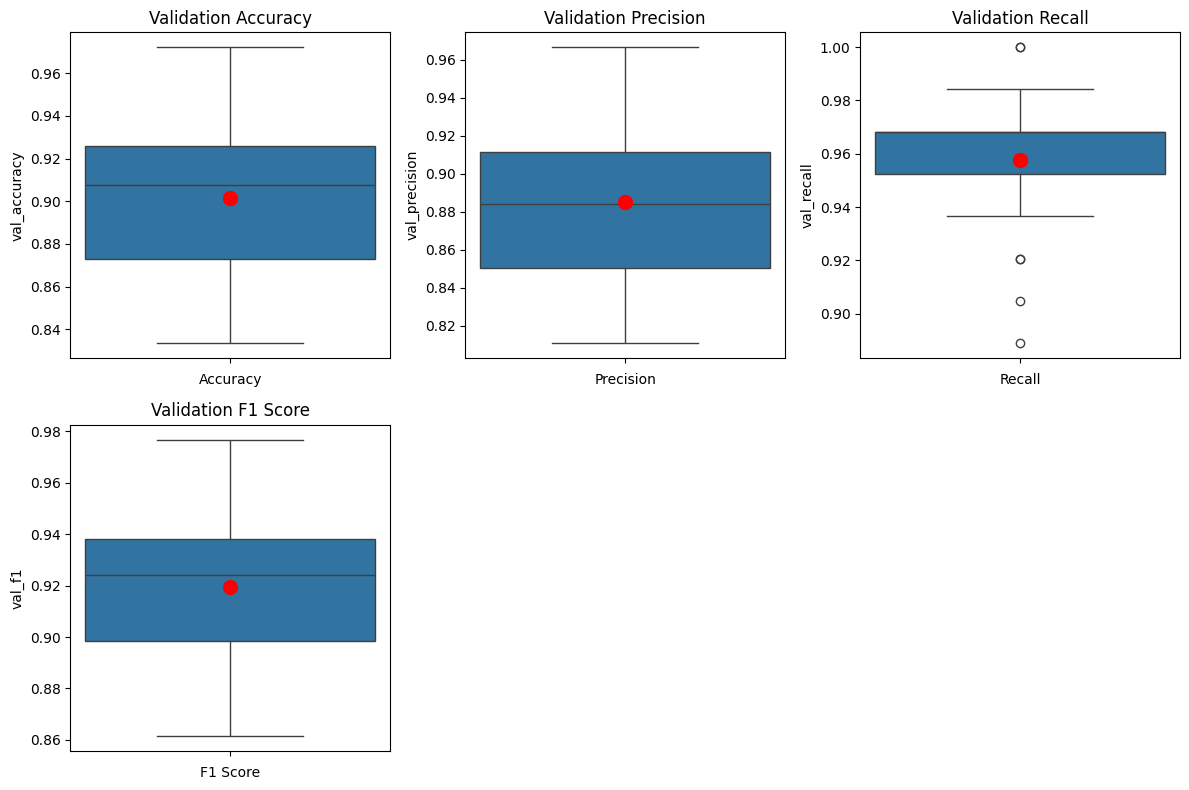

In [14]:
# Convert the metrics to a DataFrame for easier plotting
metrics_df = pd.DataFrame(all_metrics, columns=['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1'])

# Plot the box plots for each metric
plt.figure(figsize=(12, 8))

# Box plot for validation accuracy
plt.subplot(2, 3, 1)
sns.boxplot(y=metrics_df['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Accuracy')
mean_val = metrics_df['val_accuracy'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation precision
plt.subplot(2, 3, 2)
sns.boxplot(y=metrics_df['val_precision'])
plt.title('Validation Precision')
plt.xlabel('Precision')
mean_val = metrics_df['val_precision'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation recall
plt.subplot(2, 3, 3)
sns.boxplot(y=metrics_df['val_recall'])
plt.title('Validation Recall')
plt.xlabel('Recall')
mean_val = metrics_df['val_recall'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation F1 score
plt.subplot(2, 3, 4)
sns.boxplot(y=metrics_df['val_f1'])
plt.title('Validation F1 Score')
plt.xlabel('F1 Score')
mean_val = metrics_df['val_f1'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [15]:
# Save the metrics for later comparison
metrics_df.to_csv("fedMetrics/CNN1D_metrics.csv", index=False)

print("Finished Cross-Validation")

Finished Cross-Validation
